In [1]:
%load_ext autoreload

In [2]:
import os as _os
_os.chdir(_os.environ['PROJECT_ROOT'])
_os.path.realpath(_os.path.curdir)

'/pollard/home/bsmith/Projects/strain-corr'

In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from lib.pandas_util import idxwhere, align_indexes, invert_mapping
import matplotlib as mpl
import lib.plot
import statsmodels as sm
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm
import subprocess
from tempfile import mkstemp
import time
import subprocess
from itertools import chain

In [4]:
import sfacts as sf

/pollard/home/bsmith/.snakemake/conda/f8a6987d3ee0b7a0d4e1448c378762e7/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [56]:
sns.set_context('talk')
plt.rcParams['figure.dpi'] = 250

In [5]:
# sns.set_context('talk')
# plt.rcParams['figure.dpi'] = 100
stemA = 'hmp2.a.r.proc'
centroid = 75
stemB = 'filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts37-s80-seed0'
# stemB = 'filt-poly05-cvrg05.ss-g10000-block0-seed0.approx-clust2-thresh05-s95'

# Analysis Parameters

In [6]:
species_id = '102506'
# depth_ratio_bound = 3
# species_gene_corr_thresh = 0.99
# n_species_genes = 2000
species_gene_corr_thresh = 0.98

# Prepare Data

## Taxonomy

In [7]:
species_taxonomy = pd.read_table('ref/gtpro/species_taxonomy_ext.tsv', names=['genome_id', 'species_id', 'taxonomy_string']).assign(species_id=lambda x: x.species_id.astype(str)).set_index('species_id')[['taxonomy_string']].assign(taxonomy_split=lambda x: x.taxonomy_string.str.split(';'))

for level_name, level_number in [('p__', 1), ('c__', 2), ('o__', 3), ('f__', 4), ('g__', 5), ('s__', 6)]:
    species_taxonomy = species_taxonomy.assign(**{level_name: species_taxonomy.taxonomy_split.apply(lambda x: x[level_number])}) 
species_taxonomy = species_taxonomy.drop(columns=['taxonomy_split'])

species_taxonomy.loc[species_id]

taxonomy_string    d__Bacteria;p__Proteobacteria;c__Gammaproteoba...
p__                                                p__Proteobacteria
c__                                           c__Gammaproteobacteria
o__                                              o__Enterobacterales
f__                                            f__Enterobacteriaceae
g__                                                   g__Escherichia
s__                                                              s__
Name: 102506, dtype: object

In [8]:
midasdb_genomes = pd.read_table('ref_temp/uhgg_genomes_all_4644.tsv')

In [9]:
midasdb_genomes.Species_rep.value_counts()

GUT_GENOME144544    8288
GUT_GENOME143712    7507
GUT_GENOME096083    5983
GUT_GENOME143505    5750
GUT_GENOME095971    5042
                    ... 
GUT_GENOME141102       1
GUT_GENOME141101       1
GUT_GENOME141041       1
GUT_GENOME006201       1
GUT_GENOME286625       1
Name: Species_rep, Length: 4644, dtype: int64

## Species

In [10]:
all_species_depth = pd.read_table(f'data/{stemA}.gtpro.species_depth.tsv', index_col=['sample', 'species_id']).squeeze().unstack('species_id', fill_value=0).rename(str, axis='columns')
species_rabund = all_species_depth.divide(all_species_depth.sum(1), axis=0)

In [11]:
gtpro_species_depth = pd.read_table(f'data/sp-{species_id}.{stemA}.gtpro.species_depth.tsv', dtype=dict(sample=str, species_id=str, depth=float), index_col=['sample', 'species_id']).squeeze().unstack('species_id')

In [12]:
species_depth = pd.read_table(f'data_temp/sp-{species_id}.{stemA}.midas_gene{centroid}.species_depth.tsv', names=['sample', 'depth'], index_col='sample').squeeze()

In [13]:
gene_depth = xr.load_dataarray(f'data_temp/sp-{species_id}.{stemA}.midas_gene{centroid}.depth.nc').sel(sample=species_depth.index)

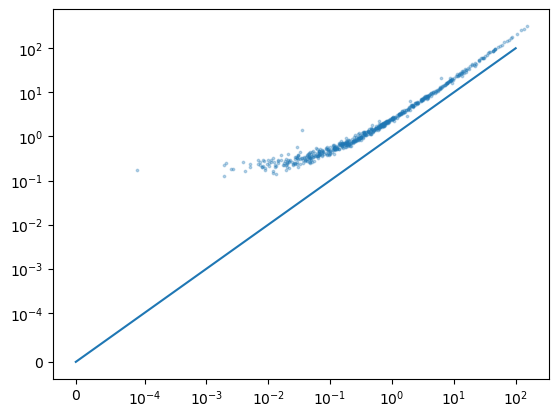

In [14]:
d = pd.DataFrame(dict(gtpro=gtpro_species_depth[species_id], midas=species_depth))

plt.scatter('gtpro', 'midas', data=d, s=3, alpha=0.3)
plt.plot([0, 1e2], [0, 1e2])
plt.yscale('symlog', linthresh=1e-4)
plt.xscale('symlog', linthresh=1e-4)

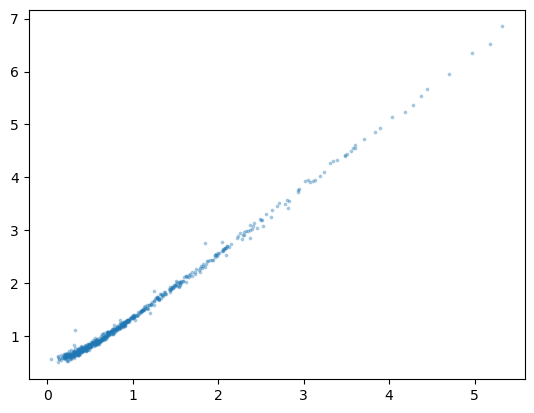

In [15]:
d = pd.DataFrame(dict(gtpro=gtpro_species_depth[species_id], midas=species_depth))

plt.scatter('gtpro', 'midas', data=np.cbrt(d), s=3, alpha=0.3)
# plt.plot([0, 1e2], [0, 1e2])
# plt.yscale('symlog', linthresh=1e-4)
# plt.xscale('symlog', linthresh=1e-4)

In [16]:
species_corr = pd.read_table(f'data_temp/sp-{species_id}.{stemA}.midas_gene{centroid}.species_correlation.tsv', names=['sample', 'correlation'], index_col='sample').squeeze()

## Metadata

In [17]:
mgen = pd.read_table('meta/hmp2/mgen.tsv', index_col='library_id')
preparation = pd.read_table('meta/hmp2/preparation.tsv', index_col='preparation_id')
stool = pd.read_table('meta/hmp2/stool.tsv', index_col='stool_id')
subject = pd.read_table('meta/hmp2/subject.tsv', index_col='subject_id')

sample_meta = mgen.join(preparation, on='preparation_id', rsuffix='_').join(stool, on='stool_id').join(subject, on='subject_id').loc[all_species_depth.index]

In [18]:
len(sample_meta.stool_id.unique()), len(sample_meta.subject_id.unique())

(1305, 106)

## Strains

In [19]:
fit = sf.World.load(
    f'data_temp/sp-{species_id}.{stemA}.gtpro.{stemB}.world.nc'
).drop_low_abundance_strains(0.05)
print(fit.sizes)

np.random.seed(0)
position_ss = fit.random_sample(position=min(fit.sizes['position'], 1000)).position

Frozen({'strain': 136, 'position': 10000, 'sample': 624, 'allele': 2})


In [20]:
strain_corr = pd.read_table(
    f'data_temp/sp-{species_id}.{stemA}.gtpro.{stemB}.midas_gene{centroid}.strain_correlation.tsv',
    index_col=['gene_id', 'strain']
).squeeze().unstack(fill_value=0)
# strain_corr = strain_by_species_corr.sel(species_id=species_id).to_series().unstack('strain')
strain_depth = pd.read_table(
    f'data_temp/sp-{species_id}.{stemA}.gtpro.{stemB}.midas_gene{centroid}.strain_depth_ratio.tsv',
    index_col=['gene_id', 'strain']
).squeeze().unstack()
strain_corr, strain_depth = align_indexes(*align_indexes(strain_corr, strain_depth), axis="columns")

In [21]:
sample_to_strain = (
    (fit.community.data > 0.95)
    .to_series()
    .unstack()
    .apply(idxwhere, axis=1)
    [lambda x: x.apply(bool)]
    .str[0]
    .rename('strain')
)
    
strain_to_sample_list = (
    sample_to_strain
    .rename('strain_id')
    .reset_index()
    .groupby('strain_id')
    .apply(lambda x: x['sample'].to_list())
)
strain_to_sample_list.apply(len).sort_values(ascending=False).head()

strain_id
8     78
34    16
22    15
7     15
36    11
dtype: int64

In [22]:
# species_gene_corr_thresh = species_corr.sort_values(ascending=False).head(n_species_genes + 1).min()
species_gene_list = idxwhere(species_corr.loc[strain_corr.index] > species_gene_corr_thresh)
print(len(species_gene_list))

566


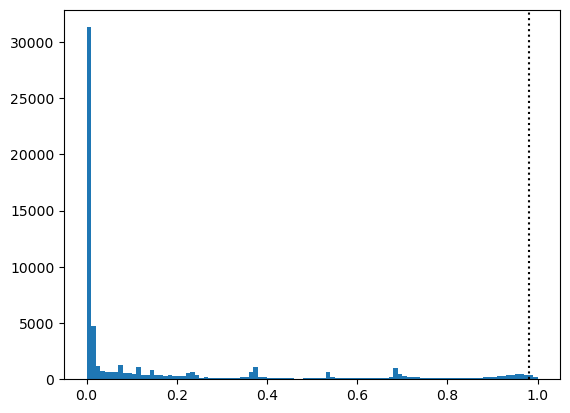

In [23]:
# strain_thresh = pd.read_table(
#     f'data_temp/sp-{species_id}.{stemA}.gtpro.{stemB}.midas_gene{centroid}.strain_correlation_threshold.tsv',
#     names=['strain_id', 'threshold'],
#     index_col='strain_id',
# ).loc[strain_corr.columns]
plt.hist(species_corr, bins=np.linspace(0, 1, num=101))
plt.axvline(species_gene_corr_thresh, linestyle=':', color='k')

In [24]:
strain_frac = pd.read_table(f'data_temp/sp-{species_id}.{stemA}.gtpro.{stemB}.comm.tsv', index_col=['sample', 'strain']).squeeze().unstack(fill_value=0)

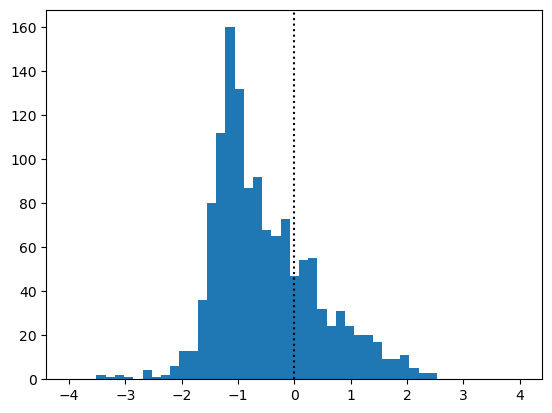

In [25]:
plt.hist(np.log10(species_depth[species_depth > 0]), bins=np.linspace(-4, 4))
plt.axvline(np.log10(1.0), linestyle=':', color='k')

## MIDAS Genes, COGs COG categories

In [26]:
gene_cluster = pd.read_table(
    f'ref_temp/midasdb_uhgg/pangenomes/{species_id}/cluster_info.txt'
).set_index('centroid_99', drop=False).rename_axis(index='gene_id')
gene_annotation = pd.read_table(
    f'ref_temp/midasdb_uhgg.sp-{species_id}.gene{centroid}_annotations.tsv',
    names=['locus_tag', 'ftype', 'length_bp', 'gene', 'EC_number', 'COG', 'product'],
    index_col='locus_tag',
).rename(columns=str.lower)

gene_meta = gene_cluster.loc[gene_cluster[f'centroid_{centroid}'].unique()].join(gene_annotation)

In [27]:
gene_cluster

,centroid_99,centroid_95,centroid_90,centroid_85,centroid_80,centroid_75,centroid_99_length,marker_id
gene_id,,,,,,,,
UHGG264295_02694,UHGG264295_02694,UHGG000489_01994,UHGG145038_05014,UHGG145038_05014,UHGG140813_01958,UHGG140813_01958,1575,NaN
UHGG055235_02557,UHGG055235_02557,UHGG055235_02557,UHGG055235_02557,UHGG055235_02557,UHGG055235_02557,UHGG055235_02557,798,NaN
UHGG096120_03929,UHGG096120_03929,UHGG096120_03929,UHGG096120_03929,UHGG096120_03929,UHGG096120_03929,UHGG096120_03929,996,NaN
UHGG000026_00004,UHGG000026_00004,UHGG000026_00004,UHGG030504_01798,UHGG144120_04301,UHGG144120_04301,UHGG144120_04301,216,NaN
UHGG000026_00005,UHGG000026_00005,UHGG001456_04534,UHGG001456_04534,UHGG001456_04534,UHGG001456_04534,UHGG001456_04534,570,NaN
...,...,...,...,...,...,...,...,...
UHGG286636_03296,UHGG286636_03296,UHGG145316_04861,UHGG145316_04861,UHGG145316_04861,UHGG145316_04861,UHGG145316_04861,303,NaN
UHGG286636_03300,UHGG286636_03300,UHGG143784_00990,UHGG143784_00990,UHGG143784_00990,UHGG143784_00990,UHGG143784_00990,522,NaN
UHGG286636_03336,UHGG286636_03336,UHGG286636_03336,UHGG188012_03408,UHGG033419_01830,UHGG033419_01830,UHGG033419_01830,411,NaN


In [28]:
_cog_meta = pd.read_table(
    'ref/cog-20.meta.tsv',
    names=['cog', 'categories', 'description', 'gene', 'pathway', '_1', '_2'],
    index_col=['cog']
)
cog_meta = _cog_meta.drop(columns=['categories', '_1', '_2'])
cog_x_category = _cog_meta.categories.apply(tuple).apply(pd.Series).unstack().to_frame(name='category').reset_index()[['cog', 'category']].dropna()

In [29]:
cog_category = pd.read_table('ref/cog-20.categories.tsv', names=['category', 'description'], index_col='category')

## Genes

In [30]:
sample_depth = xr.load_dataarray(f'data_temp/sp-{species_id}.{stemA}.midas_gene{centroid}.depth.nc')

## References

In [31]:
reference_meta = pd.read_table('ref_temp/uhgg_genomes_all_4644.tsv', index_col='Genome').rename_axis(index='genome_id')[lambda x: x.MGnify_accession == 'MGYG-HGUT-' + species_id[1:]].rename(lambda s: 'UHGG' + s[10:])
reference_meta.head()

,Genome_type,Length,N_contigs,N50,GC_content,Completeness,Contamination,Species_rep,MGnify_accession,Lineage,Continent
genome_id,,,,,,,,,,,
UHGG000026,Isolate,5095388,44,245104,50.56,99.72,0.08,GUT_GENOME144544,MGYG-HGUT-02506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Europe
UHGG000027,Isolate,4998207,106,103519,50.65,99.03,0.30,GUT_GENOME144544,MGYG-HGUT-02506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Europe
UHGG000036,Isolate,4978086,124,99332,50.65,99.27,0.35,GUT_GENOME144544,MGYG-HGUT-02506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Europe
UHGG000309,Isolate,4682102,42,653581,50.65,99.97,0.93,GUT_GENOME144544,MGYG-HGUT-02506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,North America
UHGG000316,Isolate,5046484,66,244235,50.51,99.67,0.04,GUT_GENOME144544,MGYG-HGUT-02506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Europe


In [32]:
reference_gene = xr.load_dataarray(f'data_temp/sp-{species_id}.midas_gene{centroid}.reference_copy_number.nc')
reference_gene = pd.DataFrame(reference_gene.T.values, index=reference_gene.gene_id, columns=reference_gene.genome_id)

In [33]:
isolate_gene = reference_gene[idxwhere(reference_meta.Genome_type == 'Isolate')]

# QC Strains

In [34]:
strain_thresholds = (
    pd.read_table(f'data_temp/sp-{species_id}.{stemA}.gtpro.{stemB}.midas_gene{centroid}.strain_gene_threshold.tsv', index_col='strain')
    .rename(columns=dict(
        correlation_strict='corr_threshold_strict',
        correlation_moderate='corr_threshold_moderate',
        correlation_lenient='corr_threshold_lenient',
        depth_high='depth_thresh_high',
        depth_low='depth_thresh_low',
    ))
)

In [35]:
_strain_meta = (
    strain_thresholds
    .join(fit.genotype.entropy().to_series().rename('genotype_entropy'))
    .join(fit.metagenotype.entropy().to_series().rename('metagenotype_entropy').groupby(sample_to_strain).mean().rename(int))
    .join(strain_to_sample_list.apply(len).rename('num_samples'))
    .join(species_depth.apply(np.cbrt).groupby(sample_to_strain).std().rename('depth_stdev').rename(int))
    .join(species_depth.apply(np.cbrt).groupby(sample_to_strain).max().rename('depth_max').rename(int))
    .join(species_depth.apply(np.cbrt).groupby(sample_to_strain).sum().rename('depth_sum').rename(int))
    .assign(power_index=lambda x: (x.depth_stdev * np.sqrt(x.num_samples)).fillna(0))
)
strain_meta = _strain_meta
high_power_strain_list = idxwhere((strain_meta.power_index > 1.0) & (strain_meta.metagenotype_entropy < 0.05))
print(len(high_power_strain_list))
highest_power_strain_list = strain_meta.sort_values('power_index', ascending=False).head(3).index
strain_meta.sort_values('num_samples', ascending=False)

/pollard/home/bsmith/.snakemake/conda/f8a6987d3ee0b7a0d4e1448c378762e7/lib/python3.10/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)


16


,corr_threshold_strict,corr_threshold_moderate,corr_threshold_lenient,depth_thresh_low,depth_thresh_high,genotype_entropy,metagenotype_entropy,num_samples,depth_stdev,depth_max,depth_sum,power_index
strain,,,,,,,,,,,,
8,0.979613,0.967908,0.914441,0.542215,1.922449,0.058286,0.002158,78,0.963933,5.672279,99.327870,8.513228
34,0.778813,0.667864,0.196200,0.480272,2.070389,0.124003,0.001017,16,0.519467,2.321125,17.745944,2.077869
22,0.993995,0.973642,0.782956,0.496985,2.029359,0.095271,0.001336,15,0.609751,2.882755,17.226329,2.361557
7,0.970136,0.865873,0.121738,0.448453,2.045397,0.137511,0.003036,15,0.405085,2.362697,17.114460,1.568889
36,0.999445,0.998885,0.997307,0.517724,1.751996,0.057694,0.001486,11,1.212358,6.851659,40.893615,4.020937
3,0.771826,0.720718,0.578369,0.533937,1.982550,0.175274,0.015242,10,0.828880,2.681343,15.703293,2.621150
85,0.778212,0.686151,0.102301,0.480530,1.949413,0.144607,0.010447,10,0.505457,2.157147,13.392359,1.598395
39,0.160709,0.122518,0.032313,0.318596,3.223966,0.186887,0.000937,10,0.320273,1.582000,10.074094,1.012792
27,0.926792,0.891131,0.756649,0.503473,1.881499,0.127603,0.017579,9,1.549563,4.402050,20.008324,4.648689


# Select Genes

In [36]:
strict_corr_hit = strain_corr > strain_meta.corr_threshold_strict
lenient_corr_hit = strain_corr > strain_meta.corr_threshold_lenient
moderate_corr_hit = strain_corr > strain_meta.corr_threshold_moderate
low_corr =  strain_corr < strain_meta.corr_threshold_lenient

low_depth = (strain_depth < strain_meta.depth_thresh_low)
depth_hit = ~low_depth
high_depth = (strain_depth > strain_meta.depth_thresh_high)
high_confidence_hit = depth_hit & strict_corr_hit
moderate_hit = depth_hit & moderate_corr_hit
maybe_hit = depth_hit & lenient_corr_hit
low_depth_hit = low_depth & strict_corr_hit
high_depth_hit = high_depth & strict_corr_hit
ambiguous_hit = depth_hit ^ strict_corr_hit
high_confidence_not_hit = low_depth & low_corr

/tmp/bsmith/ipykernel_34787/922024519.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  strict_corr_hit = strain_corr > strain_meta.corr_threshold_strict
/tmp/bsmith/ipykernel_34787/922024519.py:2: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  lenient_corr_hit = strain_corr > strain_meta.corr_threshold_lenient
/tmp/bsmith/ipykernel_34787/922024519.py:3: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  moderate_corr_hit = strain_corr > strain_meta.corr_threshold_moderate
/tmp/bs

In [37]:
high_confidence_hit[high_power_strain_list]

strain,1,3,6,7,8,10,16,22,27,34,36,39,53,57,67,85
gene_id,,,,,,,,,,,,,,,,
UHGG083879_00442,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
UHGG183832_04259,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
UHGG166081_00122,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
UHGG058302_01584,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
UHGG023819_03590,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UHGG047892_02199,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
UHGG143860_04853,False,False,False,False,False,False,False,True,False,False,False,False,True,True,False,False
UHGG006093_04034,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [38]:
samples_with_high_power_strains = idxwhere(fit.community.data.sel(strain=high_power_strain_list).sum("strain").to_series() > 0.5)
samples_without_high_power_strains = idxwhere(fit.community.data.sel(strain=high_power_strain_list).sum("strain").to_series() < 0.5)
len(samples_with_high_power_strains), len(samples_without_high_power_strains)

(403, 221)

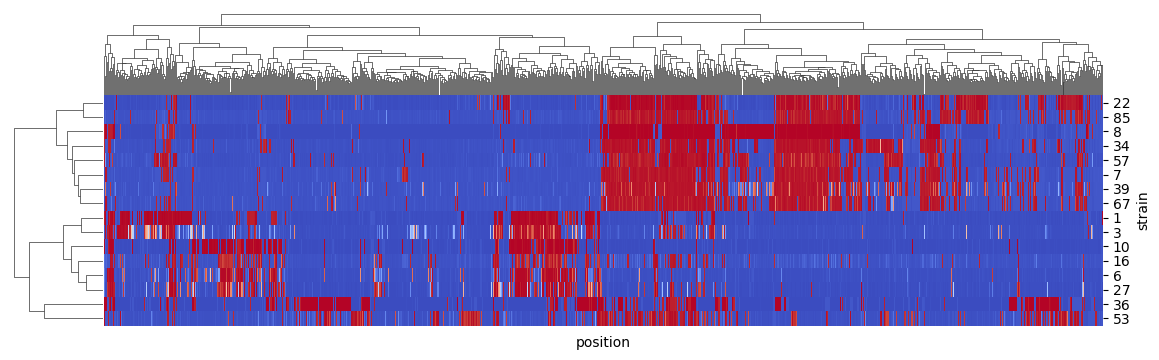

In [39]:
sf.plot.plot_genotype(
    fit.sel(strain=high_power_strain_list, position=position_ss),
    col_linkage_func=lambda w: w.metagenotype.linkage("position"),
    row_linkage_func=lambda w: w.genotype.linkage("strain"),
)

In [ ]:
sf.plot.plot_metagenotype(
    fit.sel(sample=samples_with_high_power_strains, position=position_ss),
    col_linkage_func=lambda w: w.metagenotype.linkage(),
    row_linkage_func=lambda w: w.metagenotype.linkage("position"),
)

/include/StrainFacts/sfacts/math.py:28: RuntimeWarning: invalid value encountered in float_scalars
  wmean_dist = (weight * dist).sum() / weight.sum()


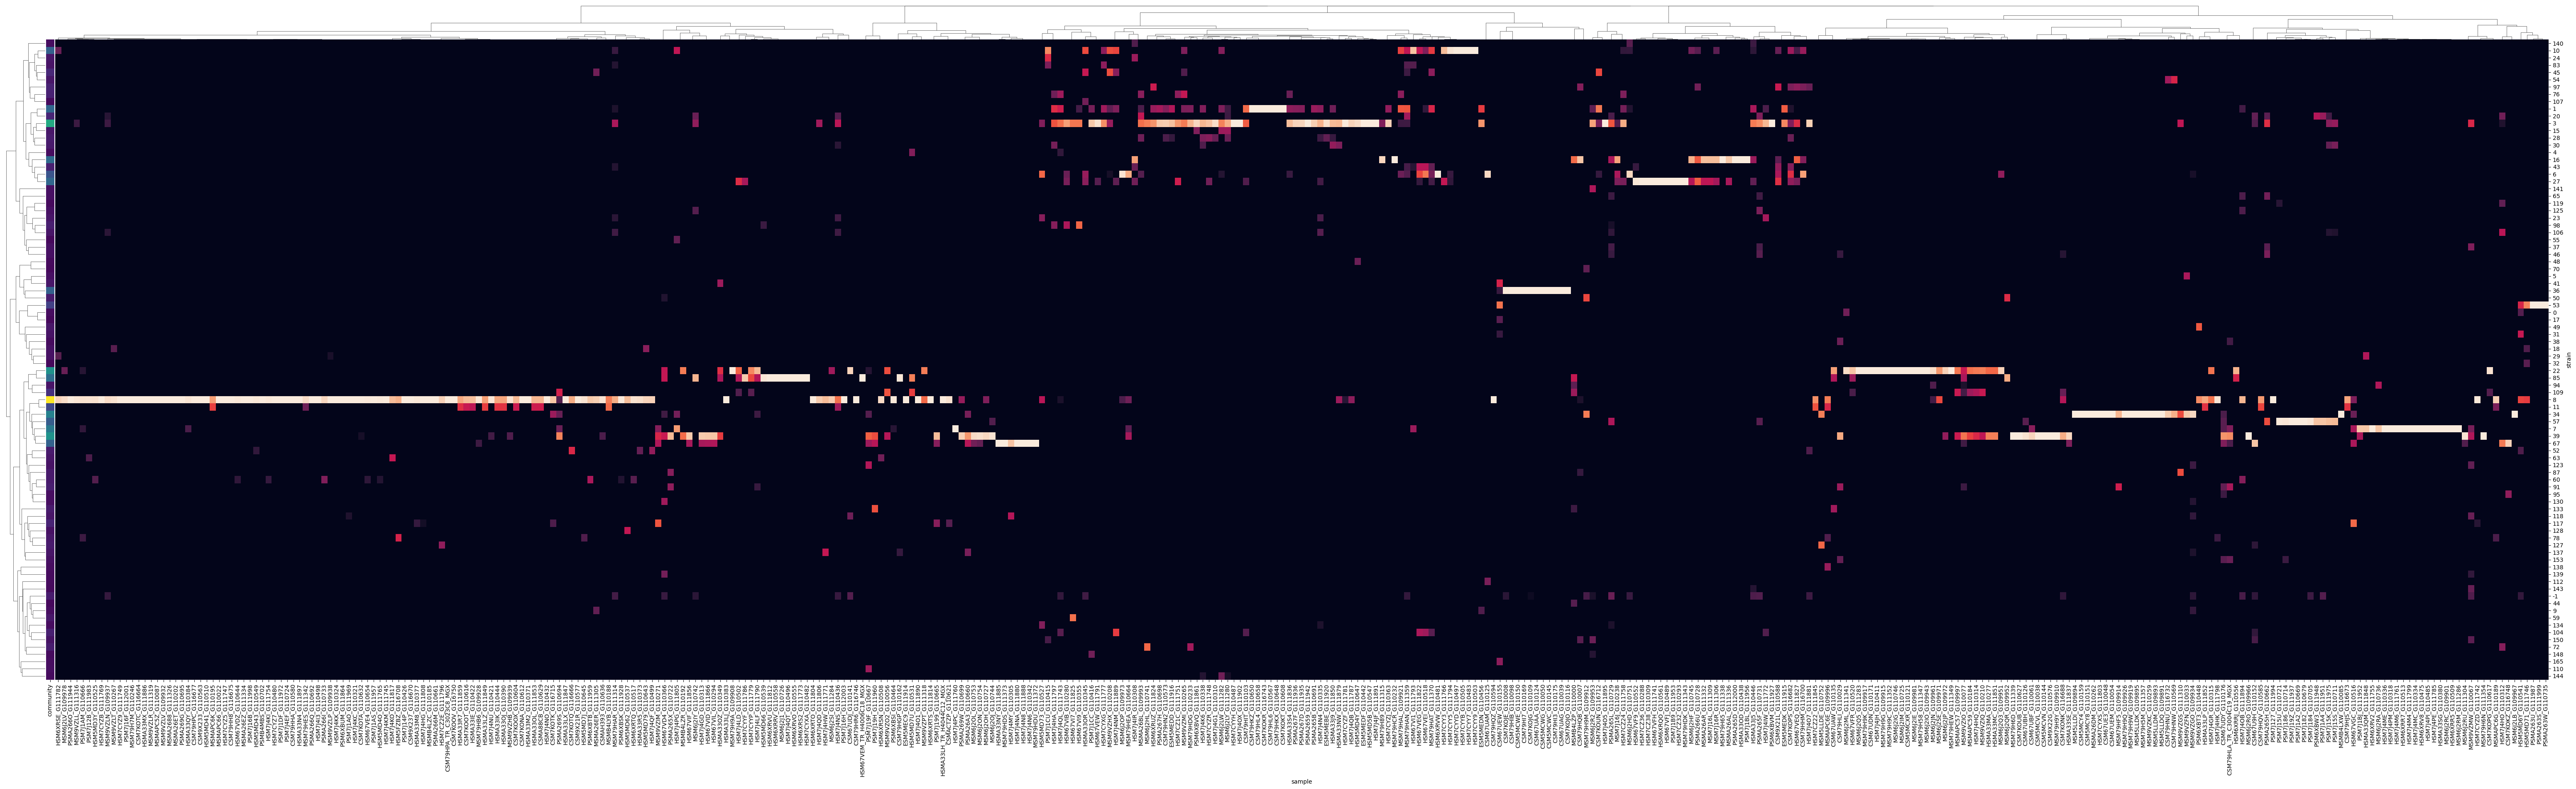

In [41]:
sf.plot.plot_community(
    fit.sel(sample=samples_with_high_power_strains, position=position_ss).drop_low_abundance_strains(0.05),
    col_linkage_func=lambda w: w.metagenotype.linkage(),
    row_linkage_func=lambda w: w.genotype.linkage("strain"),
)

# Phylogenetic conservation

SpearmanrResult(correlation=0.7004028057503993, pvalue=5.424167206575198e-19)

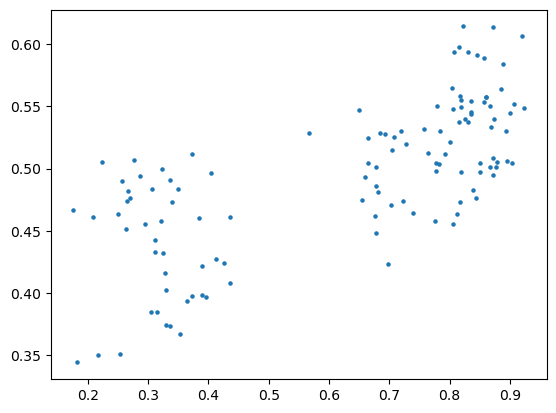

In [42]:
strain_list = high_power_strain_list

m = gene_meta.join(cog_meta, on='cog', rsuffix='_cog')
x = high_confidence_hit[strain_list]
fdist = pd.DataFrame(sp.spatial.distance.squareform(sp.spatial.distance.pdist(x.T, metric='jaccard')), index=x.columns, columns=x.columns)

gdist = fit.genotype.sel(strain=strain_list).pdist()

d = pd.DataFrame(dict(
    genotype_distance=sp.spatial.distance.squareform(gdist),
    gene_content_distance=sp.spatial.distance.squareform(fdist)
))
plt.scatter('genotype_distance', 'gene_content_distance', data=d, s=5)
sp.stats.spearmanr(d.genotype_distance, d.gene_content_distance)

SpearmanrResult(correlation=0.3467573212681823, pvalue=0.00010451313067681314)

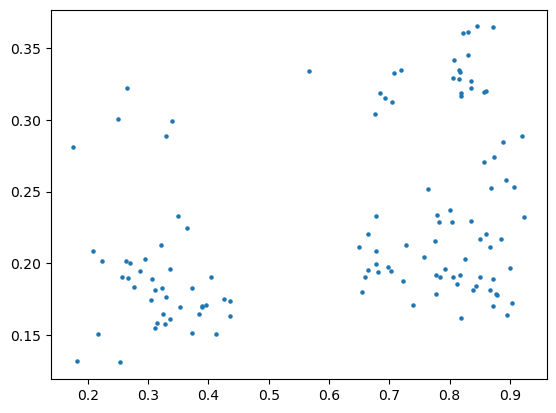

In [43]:
strain_list = high_power_strain_list

m = gene_meta.join(cog_meta, on='cog', rsuffix='_cog')
x = high_confidence_hit[strain_list].groupby(m.cog).any()
fdist = pd.DataFrame(sp.spatial.distance.squareform(sp.spatial.distance.pdist(x.T, metric='jaccard')), index=x.columns, columns=x.columns)

gdist = fit.genotype.sel(strain=strain_list).pdist()

d = pd.DataFrame(dict(
    genotype_distance=sp.spatial.distance.squareform(gdist),
    gene_content_distance=sp.spatial.distance.squareform(fdist)
))
plt.scatter('genotype_distance', 'gene_content_distance', data=d, s=5)
sp.stats.spearmanr(d.genotype_distance, d.gene_content_distance)

SpearmanrResult(correlation=0.10010590118963764, pvalue=0.27665586206882975)

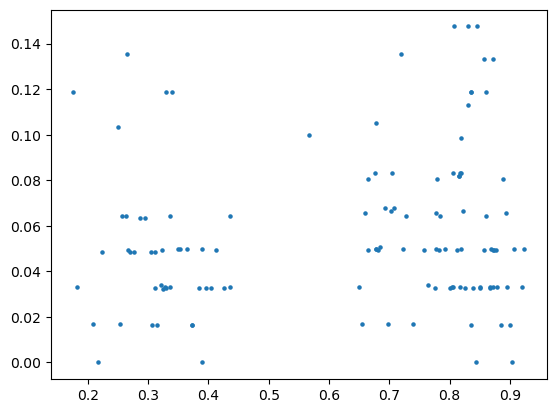

In [44]:
strain_list = high_power_strain_list

m = gene_meta.join(cog_meta, on='cog', rsuffix='_cog')
x = high_confidence_hit[strain_list].groupby(m.pathway).any()
fdist = pd.DataFrame(sp.spatial.distance.squareform(sp.spatial.distance.pdist(x.T, metric='jaccard')), index=x.columns, columns=x.columns)

gdist = fit.genotype.sel(strain=strain_list).pdist()

d = pd.DataFrame(dict(
    genotype_distance=sp.spatial.distance.squareform(gdist),
    gene_content_distance=sp.spatial.distance.squareform(fdist)
))
plt.scatter('genotype_distance', 'gene_content_distance', data=d, s=5)
sp.stats.spearmanr(d.genotype_distance, d.gene_content_distance)

In [45]:
strain_list = high_power_strain_list

tally_cog_category_reps = pd.merge(
    gene_meta.loc[idxwhere(high_confidence_hit[strain_list].any(1))].cog.value_counts().reset_index().rename(columns=dict(index='cog', cog='tally')),
    cog_x_category,
    on='cog'
).groupby('category').tally.sum().sort_values(ascending=False)
tally_cog_category_reps

/tmp/bsmith/ipykernel_34787/3545888473.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  gene_meta.loc[idxwhere(high_confidence_hit[strain_list].any(1))].cog.value_counts().reset_index().rename(columns=dict(index='cog', cog='tally')),


category
G    357
E    345
M    279
C    248
K    221
J    220
P    214
L    193
T    168
H    162
R    145
O    136
I    122
V    119
F    106
N     77
X     67
Q     54
U     54
D     45
W     43
S     37
Z      3
A      1
Name: tally, dtype: int64

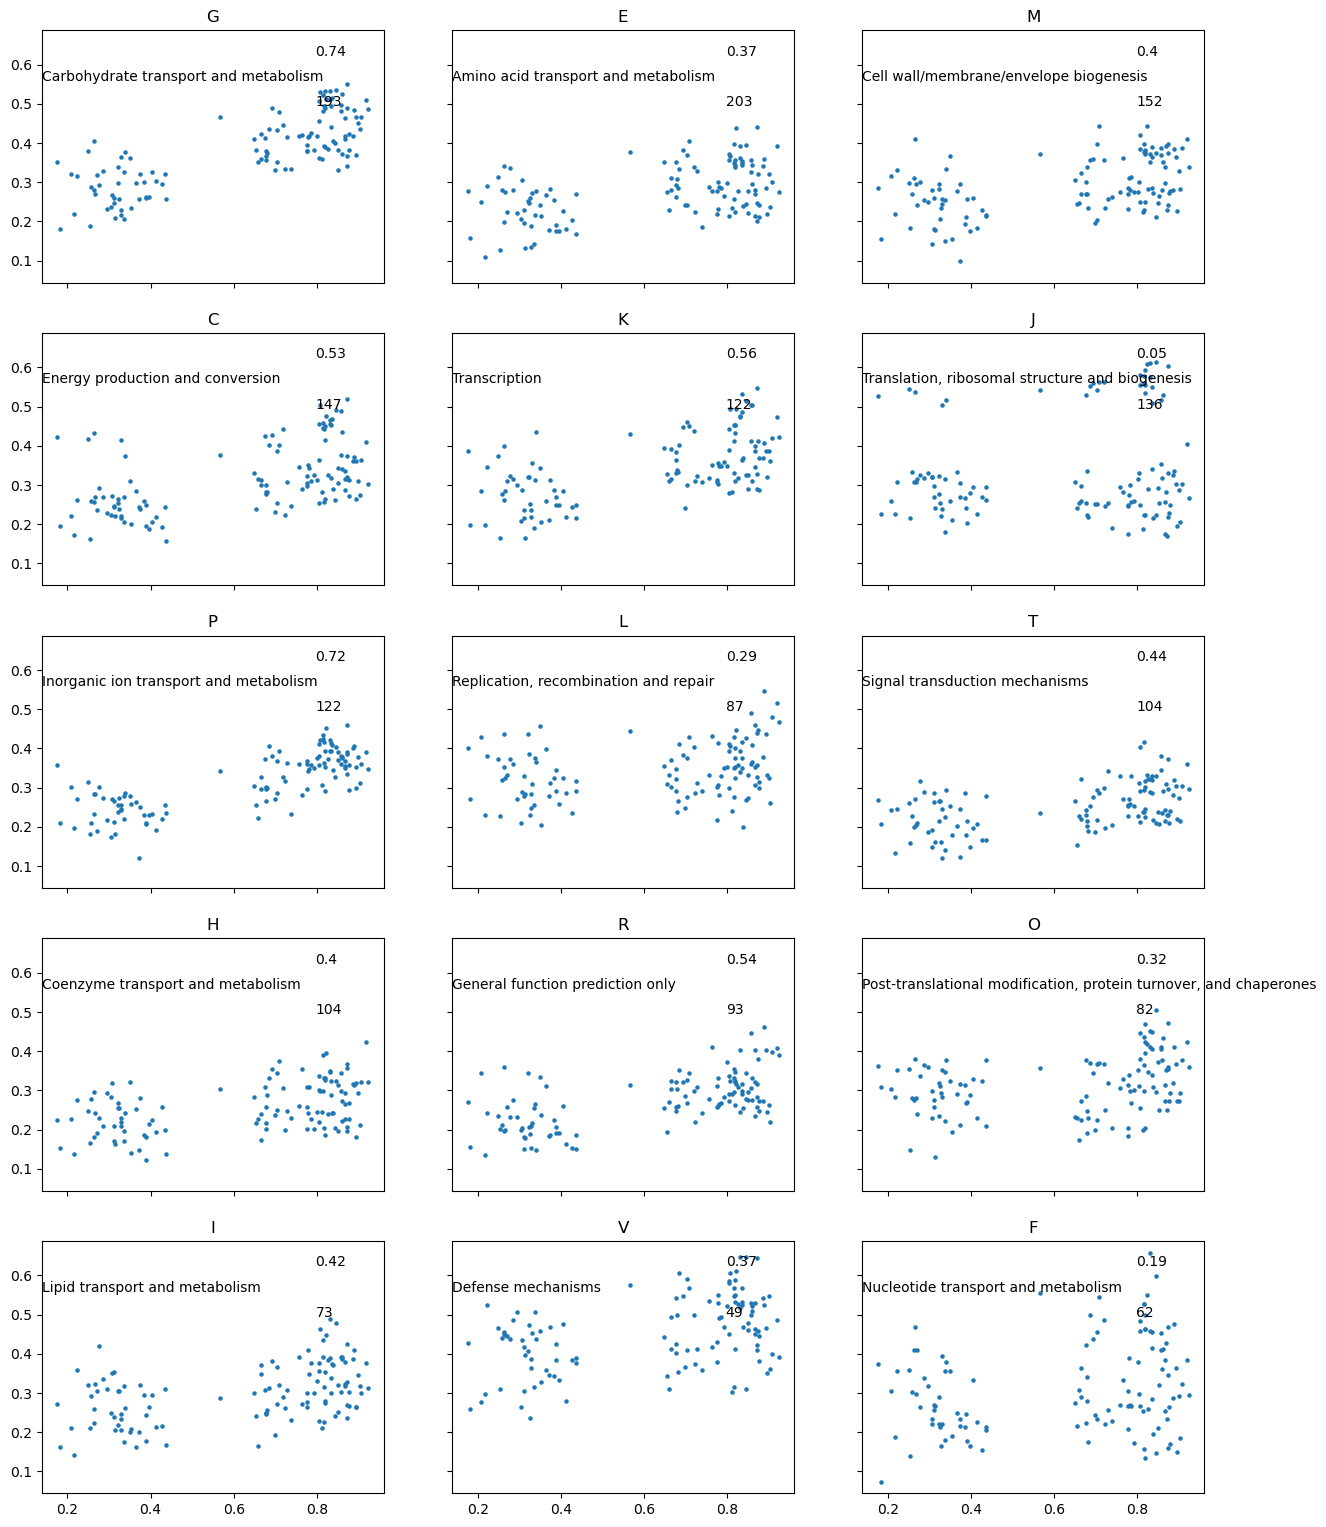

In [46]:
fig, axs = plt.subplots(5, 3, figsize=(15, 19), sharex=True, sharey=True)

for this_cog_category, ax in zip(tally_cog_category_reps.index, axs.flatten()):
    ax.set_title(this_cog_category)
    strain_list = high_power_strain_list
    cog_list = cog_x_category[cog_x_category.category == this_cog_category].cog.unique()
    gene_list = gene_meta.cog.isin(cog_list)

    x = high_confidence_hit.loc[gene_list, strain_list]
    fdist = pd.DataFrame(sp.spatial.distance.squareform(sp.spatial.distance.pdist(x.T, metric='jaccard')), index=x.columns, columns=x.columns)

    gdist = fit.genotype.sel(strain=strain_list).pdist()

    d = pd.DataFrame(dict(
        genotype_distance=sp.spatial.distance.squareform(gdist),
        gene_content_distance=sp.spatial.distance.squareform(fdist)
    ))
    ax.scatter('genotype_distance', 'gene_content_distance', data=d, s=5)
    ax.annotate(np.round(sp.stats.spearmanr(d.genotype_distance, d.gene_content_distance)[0], 2), xy=(0.8, 0.9), xycoords='axes fraction')
    ax.annotate(int(x.mean(1).sum()), xy=(0.8, 0.7), xycoords='axes fraction')
    ax.annotate(cog_category.loc[this_cog_category].description, xy=(0.0, 0.8), xycoords='axes fraction')

SpearmanrResult(correlation=0.8530954460312984, pvalue=3.924529322578613e-35)

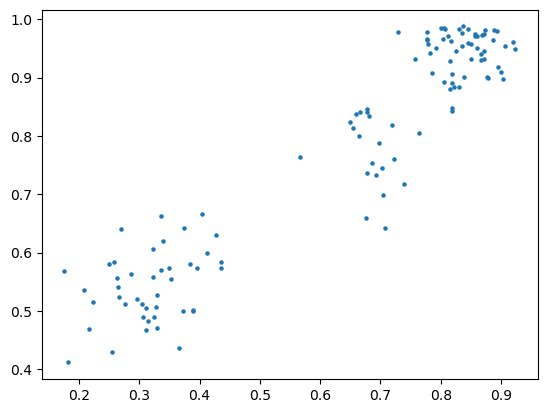

In [47]:
strain_list = high_power_strain_list
gene_list = idxwhere((moderate_hit[strain_list].mean(1) > 0.2) & (high_confidence_not_hit[strain_list].mean(1) > 0.2))

m = gene_meta.join(cog_meta, on='cog', rsuffix='_cog')
x = high_confidence_hit.loc[gene_list, strain_list]

fdist = pd.DataFrame(sp.spatial.distance.squareform(sp.spatial.distance.pdist(x.T, metric='jaccard')), index=x.columns, columns=x.columns)
gdist = fit.genotype.sel(strain=strain_list).pdist()

d = pd.DataFrame(dict(
    genotype_distance=sp.spatial.distance.squareform(gdist),
    gene_content_distance=sp.spatial.distance.squareform(fdist)
))
plt.scatter('genotype_distance', 'gene_content_distance', data=d, s=5)
sp.stats.spearmanr(d.genotype_distance, d.gene_content_distance)

/pollard/home/bsmith/.snakemake/conda/f8a6987d3ee0b7a0d4e1448c378762e7/lib/python3.10/site-packages/seaborn/matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


3229 2282

tRNA modification                           32
Fatty acid biosynthesis                     16
TCA cycle                                   16
Ribosome 50S subunit                        14
Aminoacyl-tRNA synthetases                  13
Isoleucine, leucine, valine biosynthesis    13
Menaquinone biosynthesis                    12
16S rRNA modification                       12
Glycolysis                                  12
Heme biosynthesis                           12
Name: pathway, dtype: int64

hypothetical protein                           947
Vitamin B12 import ATP-binding protein BtuD     33
putative protein                                 7
L-threonine 3-dehydrogenase                      6
HTH-type transcriptional repressor NanR          6
HTH-type transcriptional activator RhaS          5
Sialic acid transporter NanT                     5
Periplasmic nitrate reductase                    4
HTH-type transcriptional activator RhaR          4
Regulator of RpoS              

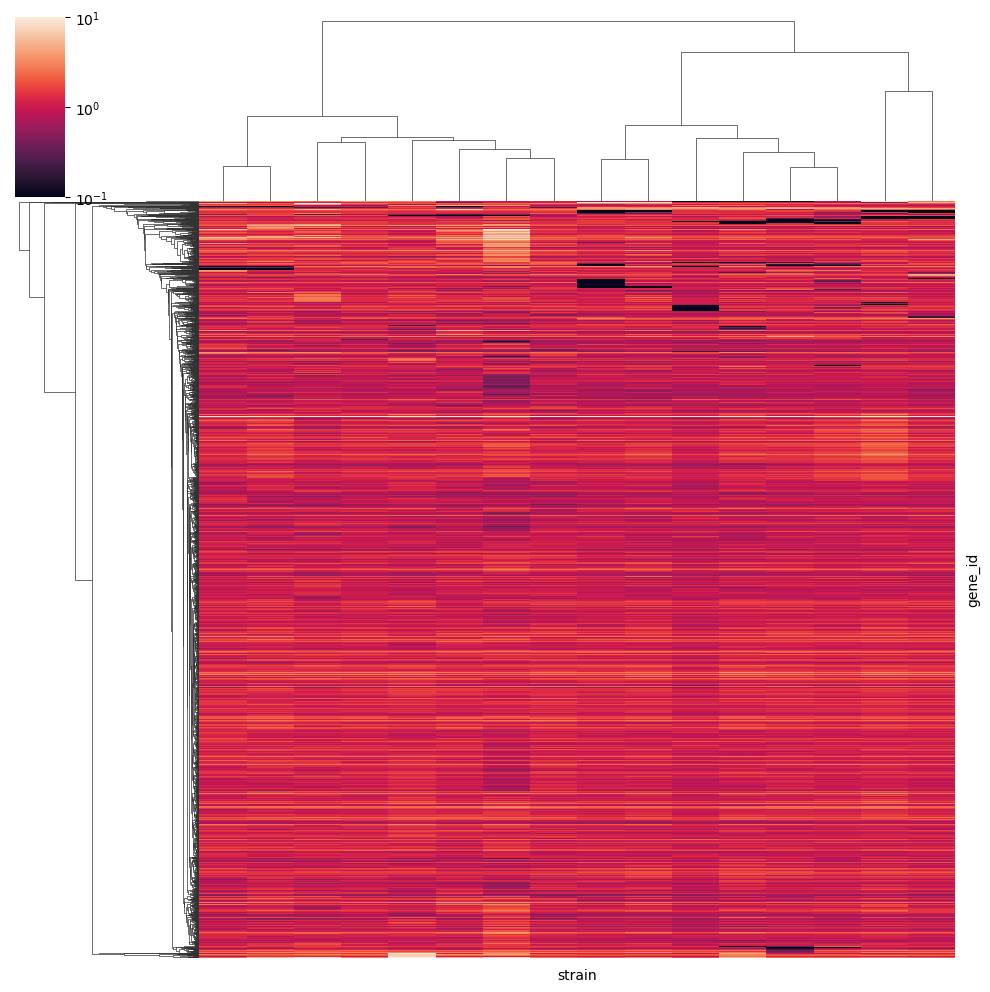

In [48]:
strain_list = high_power_strain_list
gene_list = idxwhere(moderate_hit[strain_list].mean(1) > 0.7)

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=0,
        xticklabels=0,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

print(len(gene_list), len(gene_list) - gene_annotation.loc[gene_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[gene_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[gene_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[gene_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

/pollard/home/bsmith/.snakemake/conda/f8a6987d3ee0b7a0d4e1448c378762e7/lib/python3.10/site-packages/seaborn/matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


9117 2953

tRNA modification                              21
Fatty acid biosynthesis                        18
Glycolysis                                     15
Non-phosphorylated Entner-Doudoroff pathway    14
Aromatic amino acid biosynthesis               13
TCA cycle                                      13
Cobalamine/B12 biosynthesis                    12
Ribosome 30S subunit                           10
Pyrimidine degradation                         10
Aminoacyl-tRNA synthetases                      9
Name: pathway, dtype: int64

hypothetical protein                                  6164
Tyrosine recombinase XerC                               40
Prophage integrase IntA                                 23
Vitamin B12 import ATP-binding protein BtuD             12
Prophage integrase IntS                                 12
putative protein                                        12
HTH-type transcriptional activator RhaR                 11
LexA repressor                                 

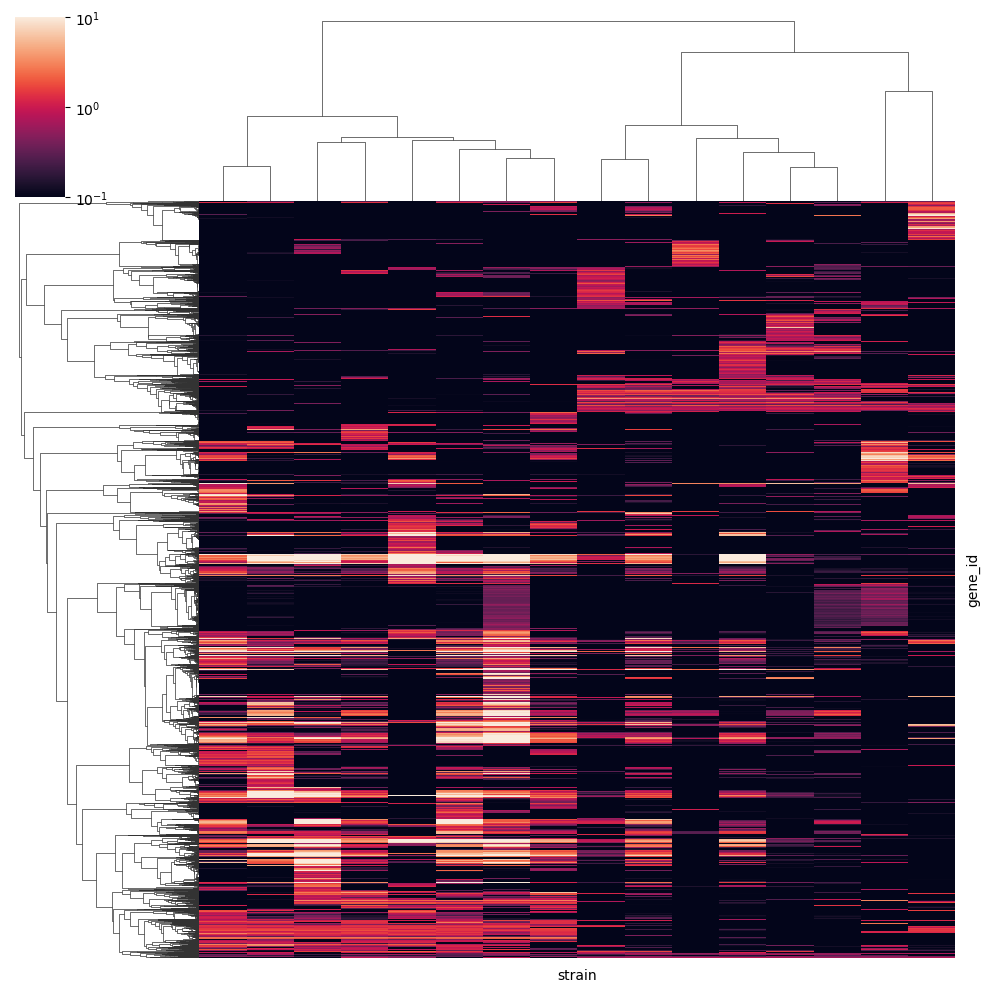

In [49]:
strain_list = high_power_strain_list
gene_list = idxwhere((moderate_hit[strain_list].mean(1) > 0.05) & (high_confidence_not_hit[strain_list].mean(1) > 0.2))

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=0,
        xticklabels=0,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

print(len(gene_list), len(gene_list) - gene_annotation.loc[gene_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[gene_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[gene_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[gene_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

/pollard/home/bsmith/.snakemake/conda/f8a6987d3ee0b7a0d4e1448c378762e7/lib/python3.10/site-packages/seaborn/matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


937 480

Aminoacyl-tRNA synthetases                  4
RNA polymerase                              3
tRNA modification                           3
Glycolysis                                  3
Purine biosynthesis                         3
Isoleucine, leucine, valine biosynthesis    2
Translation factors                         2
Pentose phosphate pathway                   2
CRISPR-Cas system                           2
Heme biosynthesis                           2
Name: pathway, dtype: int64

hypothetical protein                                    457
Vitamin B12 import ATP-binding protein BtuD              17
L-fuculose phosphate aldolase                             3
Sialic acid transporter NanT                              3
Plasmid segregation protein ParM                          3
HTH-type transcriptional repressor PurR                   3
Tyrosine recombinase XerC                                 3
p-hydroxybenzoic acid efflux pump subunit AaeA            3
3D-(3,5/4)-trihydroxyc

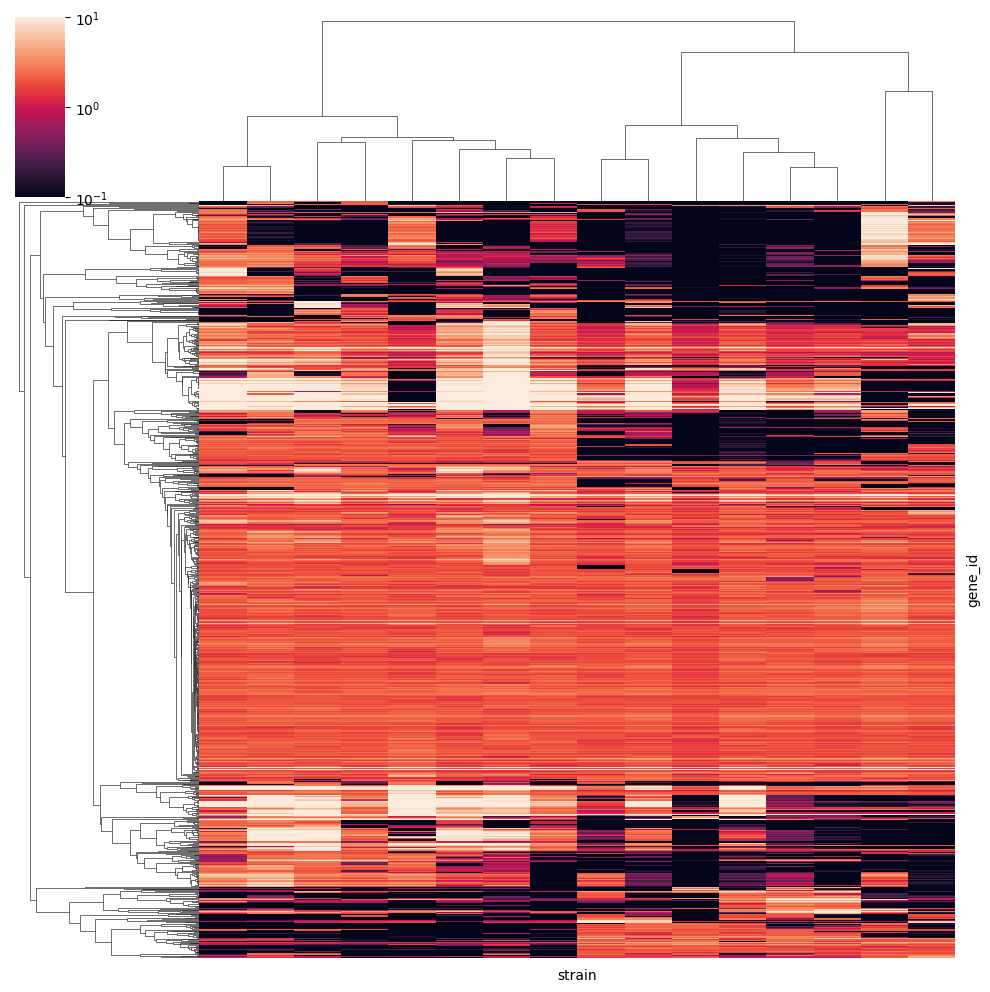

In [50]:
strain_list = high_power_strain_list
gene_list = idxwhere(high_depth_hit[strain_list].mean(1) > 0.1)

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=0,
        xticklabels=0,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

print(len(gene_list), len(gene_list) - gene_annotation.loc[gene_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[gene_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[gene_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[gene_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

SpearmanrResult(correlation=0.7004028057503993, pvalue=5.424167206575198e-19)

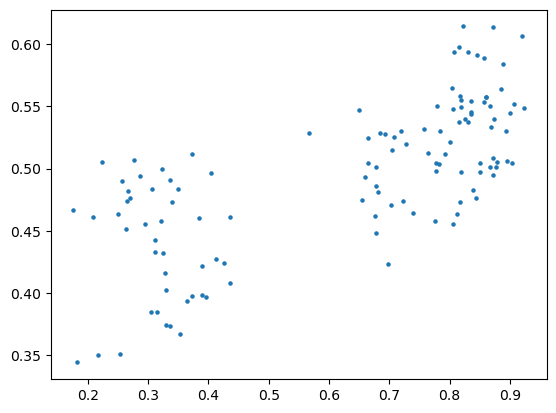

In [51]:
strain_list = high_power_strain_list
gene_list = idxwhere(high_confidence_hit[strain_list].mean(1) > 0.05)

m = gene_meta.join(cog_meta, on='cog', rsuffix='_cog')
x = high_confidence_hit.loc[gene_list, strain_list]

fdist = pd.DataFrame(sp.spatial.distance.squareform(sp.spatial.distance.pdist(x.T, metric='jaccard')), index=x.columns, columns=x.columns)
gdist = fit.genotype.sel(strain=strain_list).pdist()

d = pd.DataFrame(dict(
    genotype_distance=sp.spatial.distance.squareform(gdist),
    gene_content_distance=sp.spatial.distance.squareform(fdist)
))
plt.scatter('genotype_distance', 'gene_content_distance', data=d, s=5)
sp.stats.spearmanr(d.genotype_distance, d.gene_content_distance)

SpearmanrResult(correlation=0.5793457879019376, pvalue=4.1399230011381445e-12)

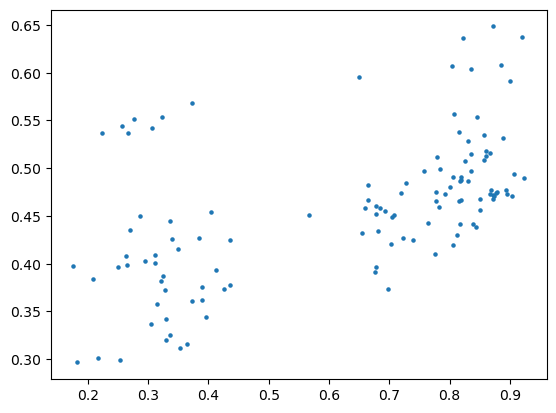

In [52]:
strain_list = high_power_strain_list
gene_list = idxwhere(moderate_hit[strain_list].mean(1) > 0.05)

m = gene_meta.join(cog_meta, on='cog', rsuffix='_cog')
x = moderate_hit.loc[gene_list, strain_list]

fdist = pd.DataFrame(sp.spatial.distance.squareform(sp.spatial.distance.pdist(x.T, metric='jaccard')), index=x.columns, columns=x.columns)
gdist = fit.genotype.sel(strain=strain_list).pdist()

d = pd.DataFrame(dict(
    genotype_distance=sp.spatial.distance.squareform(gdist),
    gene_content_distance=sp.spatial.distance.squareform(fdist)
))
plt.scatter('genotype_distance', 'gene_content_distance', data=d, s=5)
sp.stats.spearmanr(d.genotype_distance, d.gene_content_distance)

In [104]:
cog_to_category_list = (
    cog_x_category
    .groupby('cog')
    .apply(lambda x: list(x.category.unique()))
    .to_frame("categories")
    .assign(
        num_categories=lambda x: x.categories.str.len(),
        first_category=lambda x: x.categories.str[0]
    )
)
cog_to_category_list.loc[idxwhere(cog_to_category_list.num_categories > 1)]
cog_to_category = cog_to_category_list.first_category
cog_category_order = cog_to_category.unique()
cog_category_palette = lib.plot.construct_ordered_palette(cog_category_order)

gene_id
UHGG119085_01991    (0.7041906958861976, 0.09773164167627835, 0.27...
UHGG144136_05006                                                 grey
UHGG038276_00259    (0.9928489042675894, 0.716955017301038, 0.4094...
UHGG000026_01051    (0.9845444059976932, 0.6273740868896577, 0.355...
UHGG000026_00059                                                 grey
                                          ...                        
UHGG001456_04710    (0.7887735486351404, 0.19154171472510573, 0.29...
UHGG141395_00999    (0.7041906958861976, 0.09773164167627835, 0.27...
UHGG043932_02421    (0.9845444059976932, 0.6273740868896577, 0.355...
UHGG175027_00426                                                 grey
UHGG140536_01586                                                 grey
Name: gene_id, Length: 5724, dtype: object

/pollard/home/bsmith/.snakemake/conda/f8a6987d3ee0b7a0d4e1448c378762e7/lib/python3.10/site-packages/seaborn/matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


5724 3109

tRNA modification                              34
Fatty acid biosynthesis                        27
TCA cycle                                      25
Ribosome 50S subunit                           23
Glycolysis                                     22
Aminoacyl-tRNA synthetases                     19
Non-phosphorylated Entner-Doudoroff pathway    18
Isoleucine, leucine, valine biosynthesis       15
Pyrimidine degradation                         13
Ribosome 30S subunit                           12
Name: pathway, dtype: int64

hypothetical protein                           2615
Vitamin B12 import ATP-binding protein BtuD      37
Tyrosine recombinase XerC                        10
HTH-type transcriptional repressor NanR           8
Sialic acid transporter NanT                      7
putative protein                                  7
L-threonine 3-dehydrogenase                       7
HTH-type transcriptional activator RhaR           7
LexA repressor                              

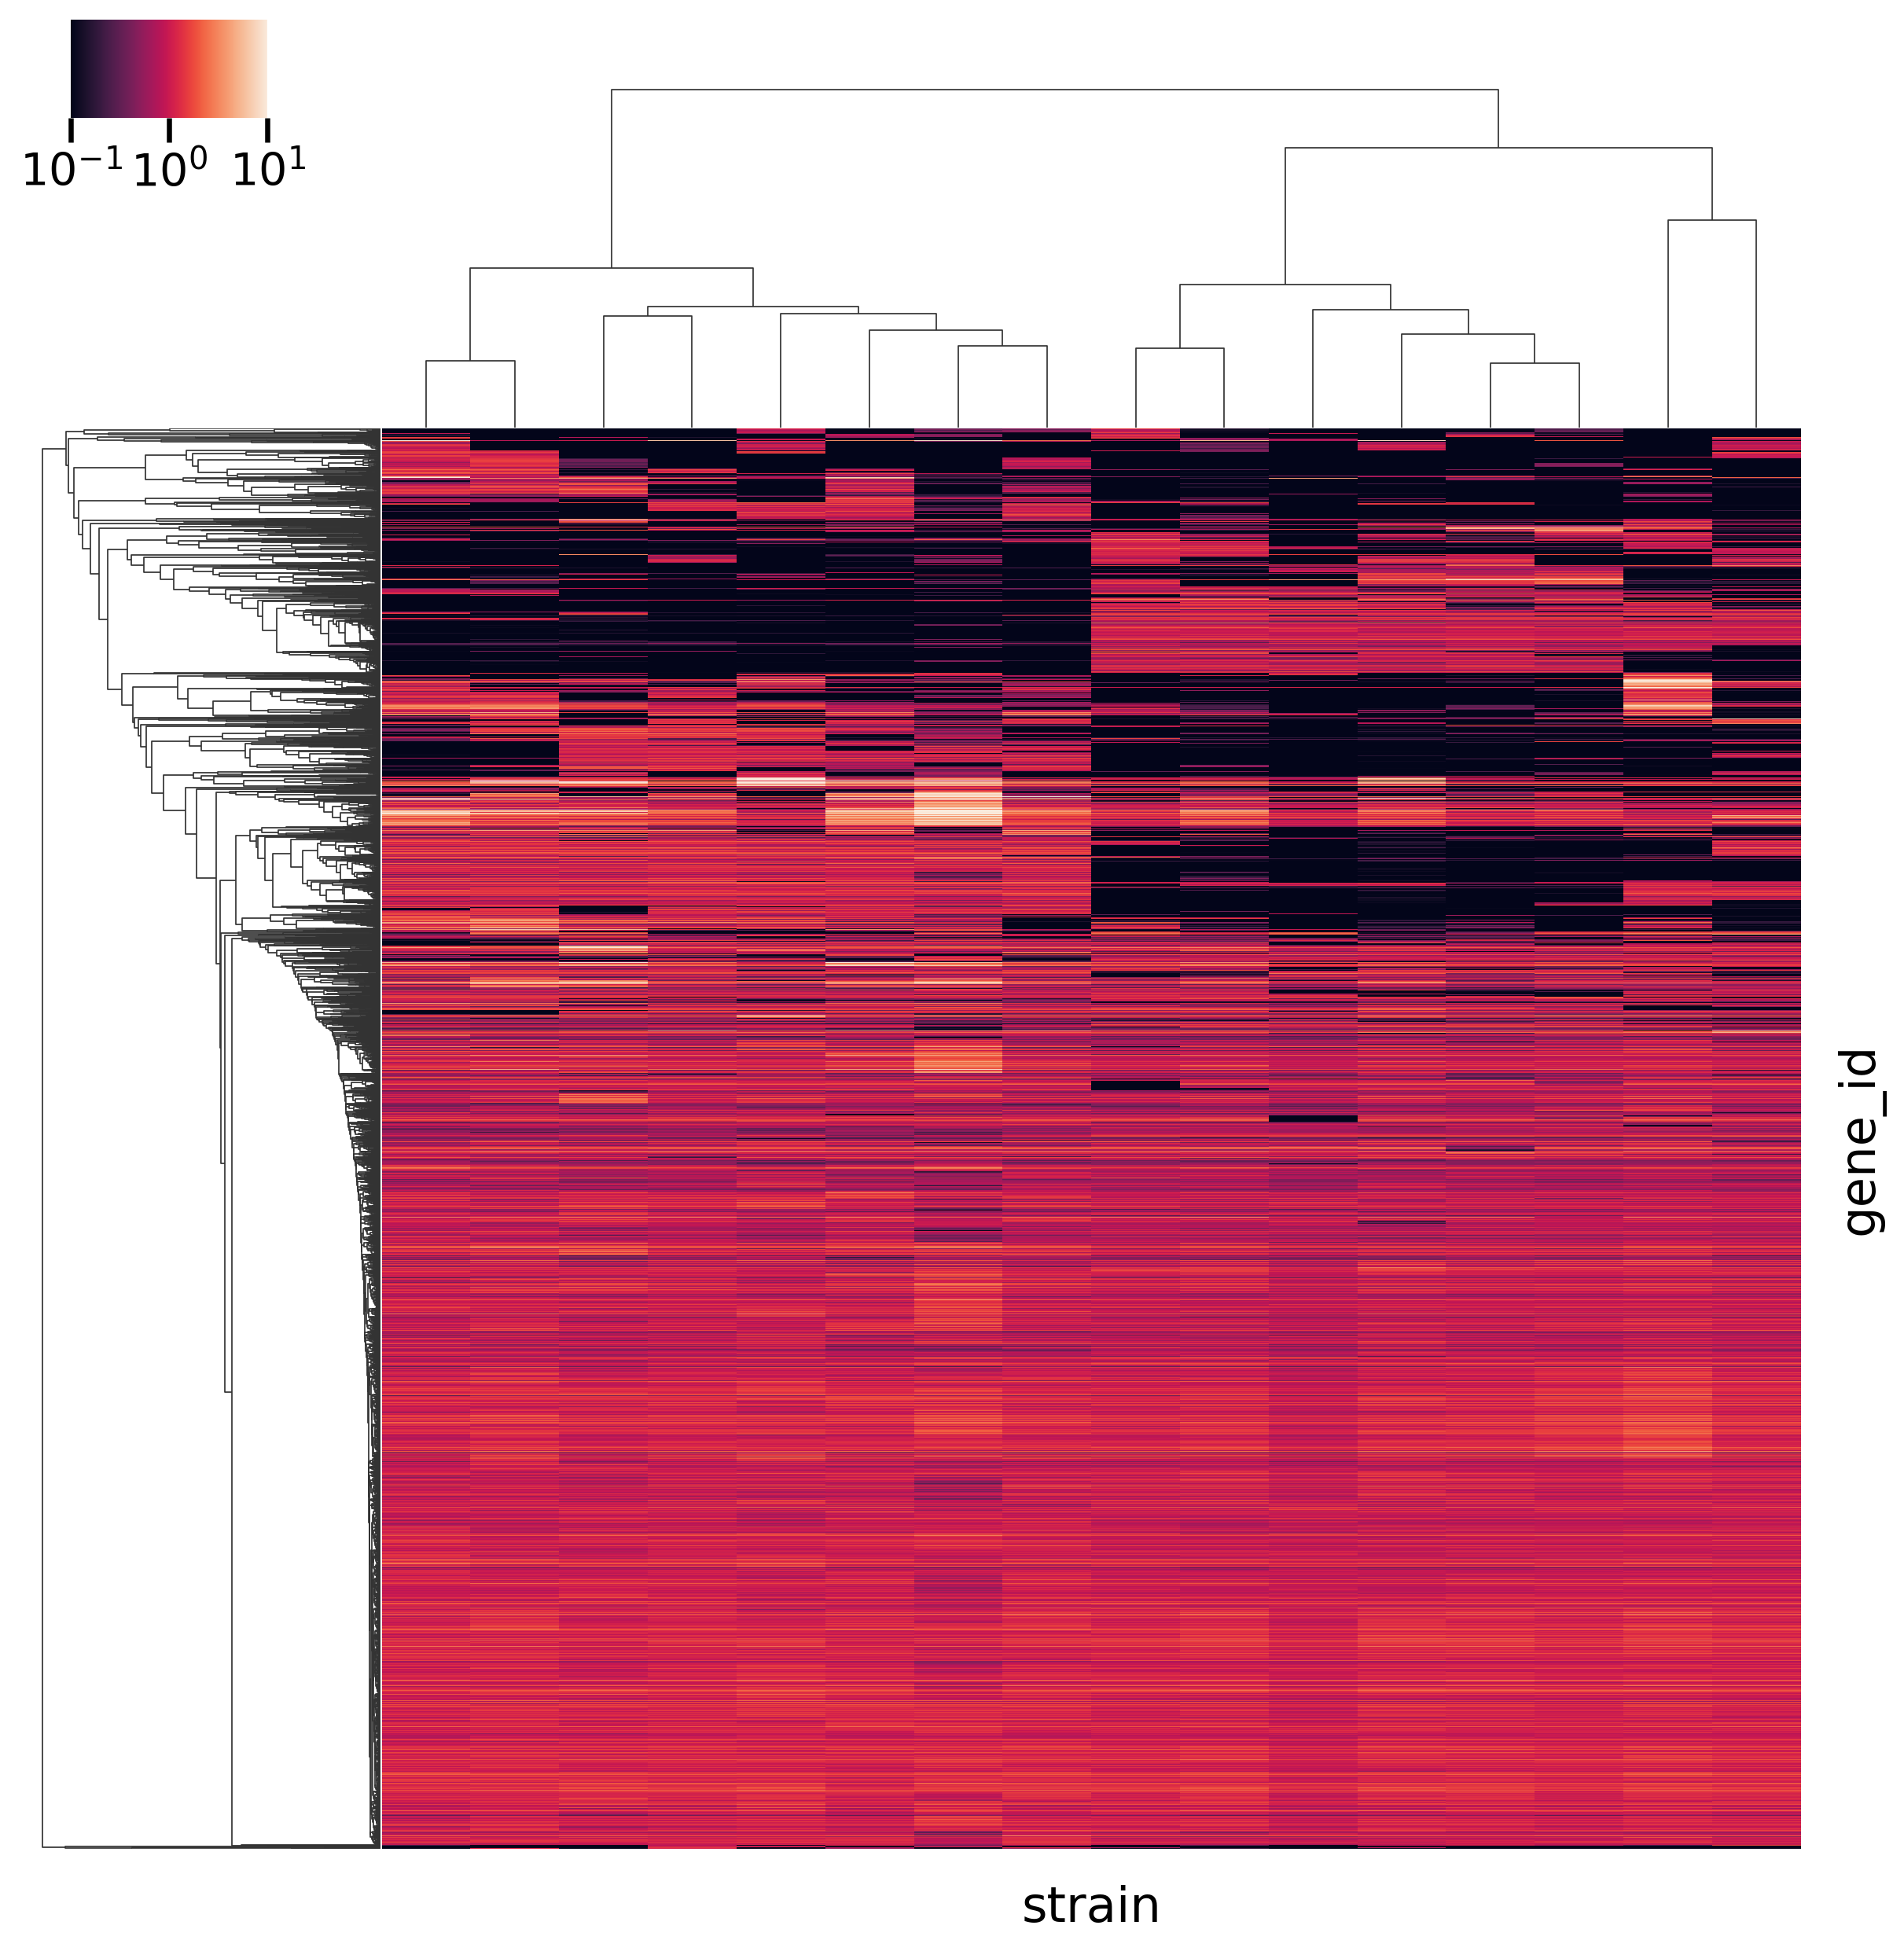

In [107]:
strain_list = high_power_strain_list
gene_list = idxwhere((moderate_hit & ~high_depth_hit)[strain_list].mean(1) > 0.15)

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=0,
        xticklabels=0,
        # row_colors=x.index.to_series().map(gene_annotation.cog).map(cog_to_category).map(cog_category_palette),
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
        cbar_pos=(0.05, 0.95, 0.1, 0.05), cbar_kws=dict(orientation='horizontal'),
        
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

print(len(gene_list), len(gene_list) - gene_annotation.loc[gene_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[gene_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[gene_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[gene_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

## What are the phylogenetically co-conserved clusters of genes?

### What about within energy metabolism

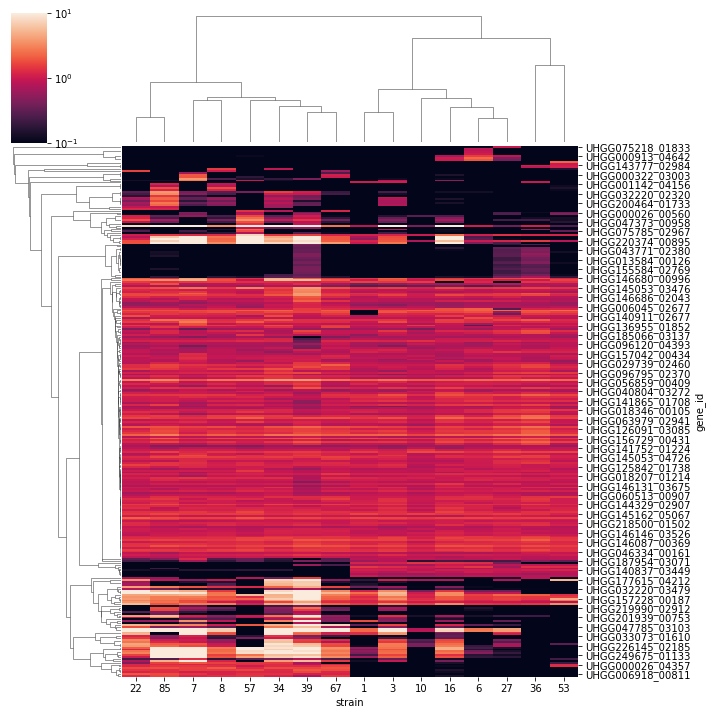

In [58]:
strain_list = high_power_strain_list
this_cog_category = 'C'
cog_list = cog_x_category[cog_x_category.category == this_cog_category].cog.unique()
gene_list = list(
    set(idxwhere(gene_meta.cog.isin(cog_list)))
    & set(idxwhere(moderate_hit[strain_list].mean(1) > 0.05))
)

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    cg = sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=5,
        xticklabels=1,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

#### TCA Cycle genes?

In [59]:
strain_list = high_power_strain_list
this_cog_pathway = 'C'
cog_list = cog_x_category[cog_x_category.category == this_cog_category].cog.unique()
gene_list = list(
    set(idxwhere(gene_meta.cog.isin(cog_list)))
    & set(idxwhere(moderate_hit[strain_list].mean(1) > 0.05))
)
# gene_list = idxwhere(high_confidence_hit[strain_list].mean(1) > 0.05)

x = strain_depth.loc[gene_list, strain_list]

tca_cycle_gene_cluster_list = idxwhere(pd.DataFrame(sp.spatial.distance.squareform(sp.spatial.distance.pdist(x, metric='cosine')), index=x.index, columns=x.index).loc['UHGG000026_04491'].sort_values() < 0.1)
print(len(tca_cycle_gene_cluster_list))
gene_meta.join(cog_meta, on='cog', rsuffix='_cog_name').loc[tca_cycle_gene_cluster_list][['gene', 'ec_number', 'cog', 'product', 'description', 'gene_cog_name', 'pathway']]

8


,gene,ec_number,cog,product,description,gene_cog_name,pathway
gene_id,,,,,,,
UHGG000026_04491,sucD_2,6.2.1.5,COG0074,Succinate--CoA ligase [ADP-forming] subunit alpha,"Succinyl-CoA synthetase, alpha subunit",SucD,TCA cycle
UHGG145453_00954,sucC_1,6.2.1.5,COG0045,Succinate--CoA ligase [ADP-forming] subunit beta,"Succinyl-CoA synthetase, beta subunit",SucC,TCA cycle
UHGG000026_04487,sucA_2,1.2.4.2,COG0567,2-oxoglutarate dehydrogenase E1 component,"2-oxoglutarate dehydrogenase complex, dehydrog...",SucA,TCA cycle
UHGG006918_00811,sucB,2.3.1.61,COG0508,Dihydrolipoyllysine-residue succinyltransferas...,"Pyruvate/2-oxoglutarate dehydrogenase complex,...",AceF,Pyruvate oxidation
UHGG000026_04493,ldh,1.1.1.27,COG2055,L-lactate dehydrogenase,"Malate/lactate/ureidoglycolate dehydrogenase, ...",AllD,TCA cycle
UHGG000026_03502,yjmC,1.1.1.-,COG2055,putative oxidoreductase YjmC,"Malate/lactate/ureidoglycolate dehydrogenase, ...",AllD,TCA cycle
UHGG000026_01619,adh1,1.1.1.192,COG1454,Long-chain-alcohol dehydrogenase 1,"Alcohol dehydrogenase, class IV",EutG,NaN
UHGG000026_04357,fdrA_3,NaN,COG0074,Protein FdrA,"Succinyl-CoA synthetase, alpha subunit",SucD,TCA cycle


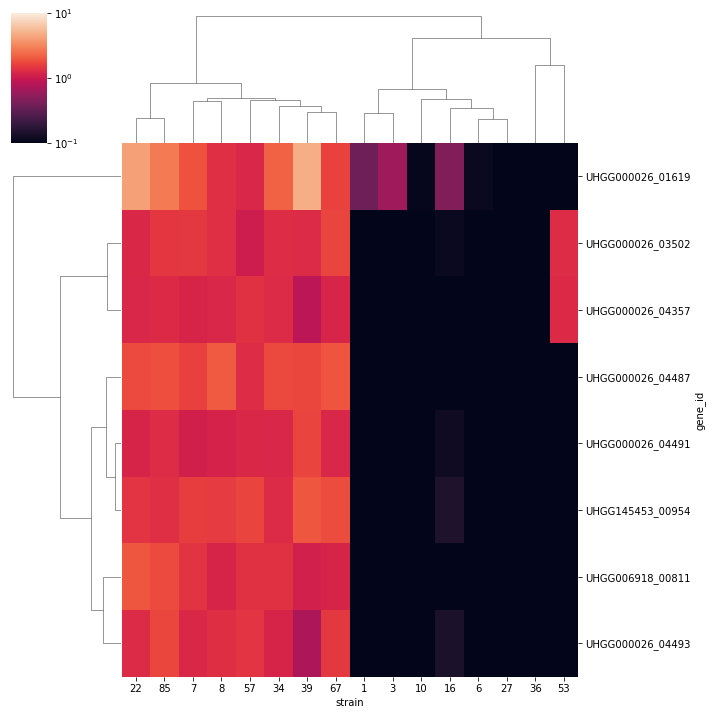

In [60]:
strain_list = high_power_strain_list
gene_list = tca_cycle_gene_cluster_list

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    cg = sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=1,
        xticklabels=1,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

In [168]:
yes_clust_x_strains = [22, 85, 7, 8, 57, 34, 39, 67]
no_clust_x_strains = [1, 3, 10, 16, 6, 27, 36, 53]
no_clust_x_strain_samples = idxwhere(sample_to_strain.isin(no_clust_x_strains))
yes_clust_x_strain_samples = idxwhere(sample_to_strain.isin(yes_clust_x_strains))

sp.stats.mannwhitneyu(species_rabund[species_id][no_clust_x_strain_samples], species_rabund[species_id][yes_clust_x_strain_samples])

MannwhitneyuResult(statistic=6030.0, pvalue=3.30662025122643e-08)

/pollard/home/bsmith/.snakemake/conda/204b2d5e194d4cedcf565e20990467c9/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


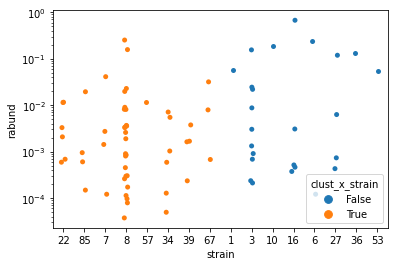

In [169]:
d = sample_to_strain.to_frame('strain').assign(rabund=species_rabund[species_id]).join(sample_meta).groupby(['subject_id', 'strain']).rabund.mean().reset_index().assign(clust_x_strain=lambda x: x.strain.isin(yes_clust_x_strains))
sns.stripplot('strain', 'rabund', data=d, hue='clust_x_strain', order=yes_clust_x_strains + no_clust_x_strains)
plt.yscale('log')

In [170]:
import lib.stats

In [171]:
lib.stats.mannwhitneyu('clust_x_strain', 'rabund', data=d)

(0.5186129525752168, 0.7229925754888491)

/pollard/home/bsmith/.snakemake/conda/204b2d5e194d4cedcf565e20990467c9/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


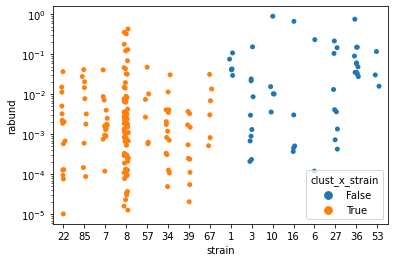

In [93]:
d = sample_to_strain.to_frame('strain').assign(rabund=species_rabund[species_id])


(array([3.254e+03, 1.710e+02, 4.700e+01, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.400e+01, 8.000e+01, 3.200e+02]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

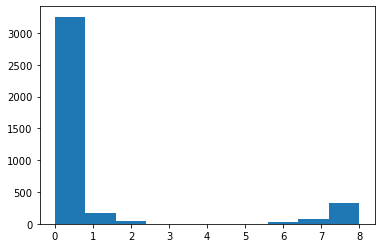

In [61]:
gene_list = tca_cycle_gene_cluster_list

x = (isolate_gene > 0).reindex(gene_list).fillna(False)
plt.hist(x.sum())

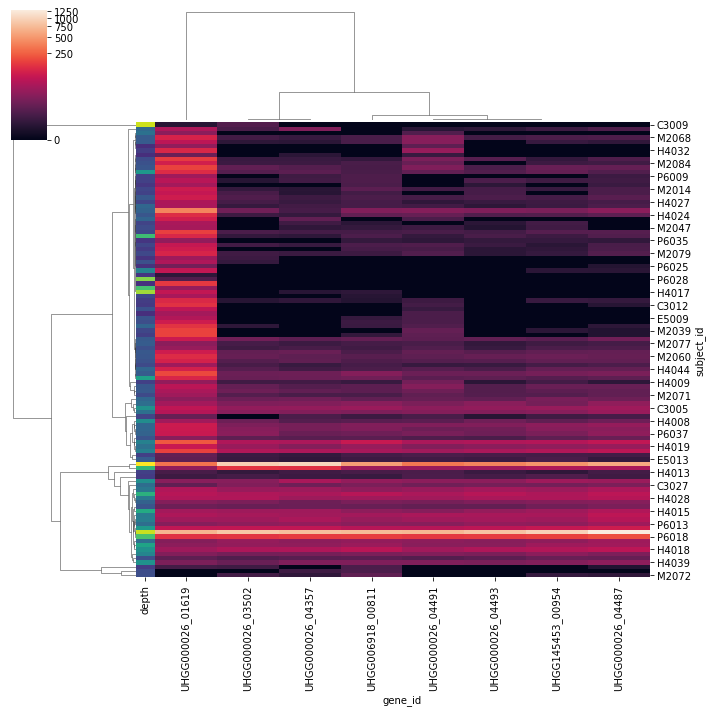

In [62]:
d = gene_depth.sel(gene_id=tca_cycle_gene_cluster_list).to_series().unstack('gene_id').groupby(sample_meta.subject_id).sum()
c = species_depth.groupby(sample_meta.subject_id).sum()
c = (c/c.max())**(1/4)

sns.clustermap(
    d + 1e-4,
    row_colors=c.map(mpl.cm.viridis),
    metric='cosine',
    norm=mpl.colors.PowerNorm(1/4),
)


#### Respiration genes?

In [63]:
strain_list = high_power_strain_list
this_cog_pathway = 'C'
cog_list = cog_x_category[cog_x_category.category == this_cog_category].cog.unique()
gene_list = list(
    set(idxwhere(gene_meta.cog.isin(cog_list)))
    & set(idxwhere(moderate_hit[strain_list].mean(1) > 0.05))
)
# gene_list = idxwhere(high_confidence_hit[strain_list].mean(1) > 0.05)

x = strain_depth.loc[gene_list, strain_list]

respiration_gene_cluster_list = idxwhere(pd.DataFrame(sp.spatial.distance.squareform(sp.spatial.distance.pdist(x, metric='cosine')), index=x.index, columns=x.index).loc['UHGG144268_03892'].sort_values() < 0.1)
print(len(respiration_gene_cluster_list))
gene_meta.join(cog_meta, on='cog', rsuffix='_cog_name').loc[respiration_gene_cluster_list][['gene', 'ec_number', 'cog', 'product', 'description', 'gene_cog_name', 'pathway']]

7


,gene,ec_number,cog,product,description,gene_cog_name,pathway
gene_id,,,,,,,
UHGG144268_03892,yeaX,1.14.13.239,COG1018,Carnitine monooxygenase reductase subunit,Flavodoxin/ferredoxin--NADP reductase,Fpr,NaN
UHGG017636_02370,hyfC,1.-.-.-,COG0650,Hydrogenase-4 component C,Formate hydrogenlyase subunit HyfC,HyfC,NaN
UHGG149669_00141,hycG_1,NaN,COG3260,Formate hydrogenlyase subunit 7,"Ni,Fe-hydrogenase III small subunit",HycG,NaN
UHGG143931_02665,lsrG,5.3.1.32,COG1359,"(4S)-4-hydroxy-5-phosphonooxypentane-2,3-dione...",Quinol monooxygenase YgiN,YgiN,NaN
UHGG140837_03449,hyfA_1,1.-.-.-,COG1142,Hydrogenase-4 component A,Fe-S-cluster-containing hydrogenase component 2,HycB,NaN
UHGG145053_01672,dcuD_1,NaN,COG3069,Putative cryptic C4-dicarboxylate transporter ...,C4-dicarboxylate transporter DcuC,DcuC,NaN
UHGG116604_00168,nuoL_1,7.1.1.-,COG1009,NADH-quinone oxidoreductase subunit L,Membrane H+-translocase/NADH:ubiquinone oxidor...,NuoL,NADH dehydrogenase


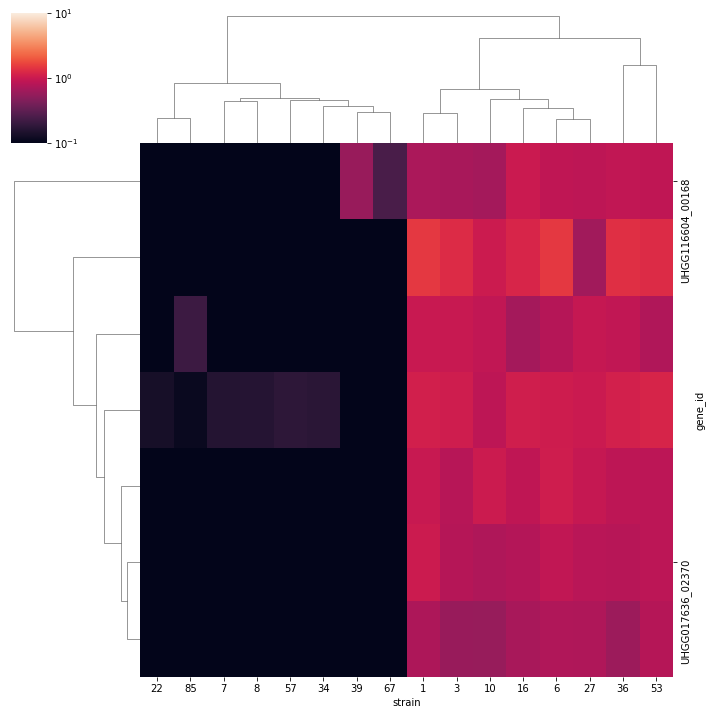

In [64]:
strain_list = high_power_strain_list
gene_list = respiration_gene_cluster_list

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    cg = sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=5,
        xticklabels=1,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

In [77]:
no_clust_x_strains = [22, 85, 7, 8, 57, 34, 39, 67]
yes_clust_x_strains = [1, 3, 10, 16, 6, 27, 36, 53]
no_clust_x_strain_samples = idxwhere(sample_to_strain.isin(no_clust_x_strains))
yes_clust_x_strain_samples = idxwhere(sample_to_strain.isin(yes_clust_x_strains))

sp.stats.mannwhitneyu(species_rabund[species_id][no_clust_x_strain_samples], species_rabund[species_id][yes_clust_x_strain_samples])

MannwhitneyuResult(statistic=1926.0, pvalue=3.30662025122643e-08)

(array([ 364.,   41.,   13.,    0.,   22.,   16.,    0.,   43., 1614.,
        1784.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

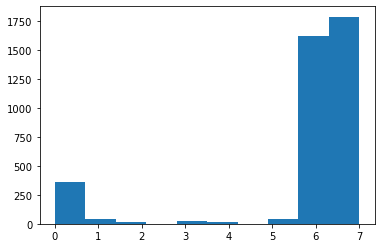

In [65]:
gene_list = respiration_gene_cluster_list

x = (isolate_gene > 0).reindex(gene_list).fillna(False)
plt.hist(x.sum())

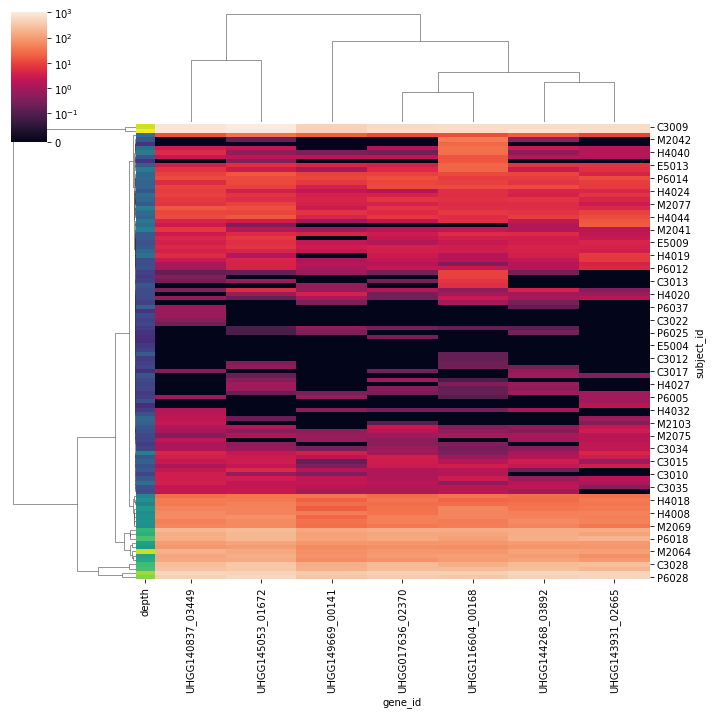

In [66]:
d = gene_depth.sel(gene_id=respiration_gene_cluster_list).to_series().unstack('gene_id').groupby(sample_meta.subject_id).sum()
c = species_depth.groupby(sample_meta.subject_id).sum()
c = (c/c.max())**(1/4)

sns.clustermap(
    d,
    row_colors=c.map(mpl.cm.viridis),
    # metric='cosine',
    norm=mpl.colors.SymLogNorm(1e-1),
)


### What about within carb metab?

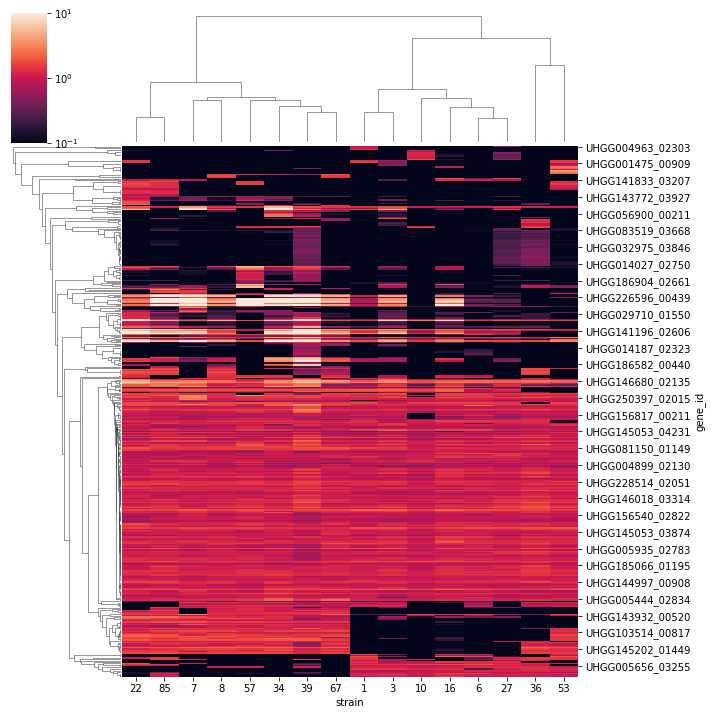

In [116]:
strain_list = high_power_strain_list
this_cog_category = 'G'
cog_list = cog_x_category[cog_x_category.category == this_cog_category].cog.unique()
gene_list = list(
    set(idxwhere(gene_meta.cog.isin(cog_list)))
    & set(idxwhere(moderate_hit[strain_list].mean(1) > 0.05))
)

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    cg = sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=13,
        xticklabels=1,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

#### Ribose import genes?

In [117]:
strain_list = high_power_strain_list
this_cog_pathway = 'C'
cog_list = cog_x_category[cog_x_category.category == this_cog_category].cog.unique()
gene_list = list(
    set(idxwhere(gene_meta.cog.isin(cog_list)))
    & set(idxwhere(high_confidence_hit[strain_list].mean(1) > 0.05))
)
guide_gene = 'UHGG000489_02378'
# gene_list = idxwhere(high_confidence_hit[strain_list].mean(1) > 0.05)

x = strain_depth.loc[gene_list, strain_list]

_gene_cluster_list = idxwhere(pd.DataFrame(sp.spatial.distance.squareform(sp.spatial.distance.pdist(x, metric='cosine')), index=x.index, columns=x.index).loc[guide_gene].sort_values() < 0.1)
print(len(_gene_cluster_list))

ribose_gene_cluster_list = _gene_cluster_list  # FIXME

gene_meta.join(cog_meta, on='cog', rsuffix='_cog_name').loc[_gene_cluster_list][['gene', 'ec_number', 'cog', 'product', 'description', 'gene_cog_name', 'pathway']]

5


,gene,ec_number,cog,product,description,gene_cog_name,pathway
gene_id,,,,,,,
UHGG000489_02378,aptB,2.2.1.-,COG3958,Apulose-4-phosphate transketolase subunit B,"Transketolase, C-terminal subunit",TktA2,NaN
UHGG000489_02370,rbsC_2,NaN,COG1172,Ribose import permease protein RbsC,Ribose/xylose/arabinose/galactoside ABC-type t...,AraH,NaN
UHGG000489_02374,rbsB_2,NaN,COG1879,Ribose import binding protein RbsB,"ABC-type sugar transport system, periplasmic c...",RbsB,NaN
UHGG006626_01704,rbsA_2,7.5.2.7,COG1129,Ribose import ATP-binding protein RbsA,"ABC-type sugar transport system, ATPase component",MglA,NaN
UHGG000489_02377,aptA,2.2.1.-,COG3959,Apulose-4-phosphate transketolase subunit A,"Transketolase, N-terminal subunit",TktA1,NaN


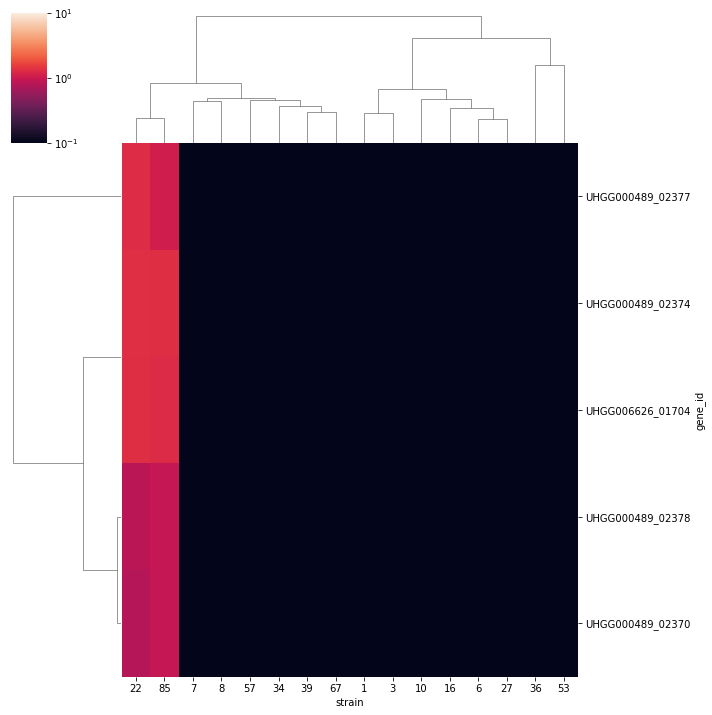

In [118]:
strain_list = high_power_strain_list
gene_list = ribose_gene_cluster_list

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    cg = sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=1,
        xticklabels=1,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

(array([7492.,    0.,   11.,    0.,   20.,    0.,   22.,    0.,   33.,
         710.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

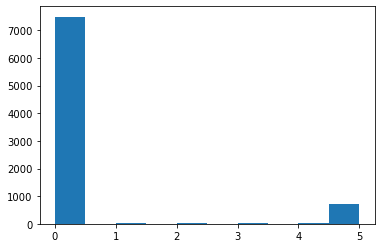

In [119]:
gene_list = ribose_gene_cluster_list

x = (reference_gene > 0).reindex(gene_list).fillna(False)
plt.hist(x.sum())

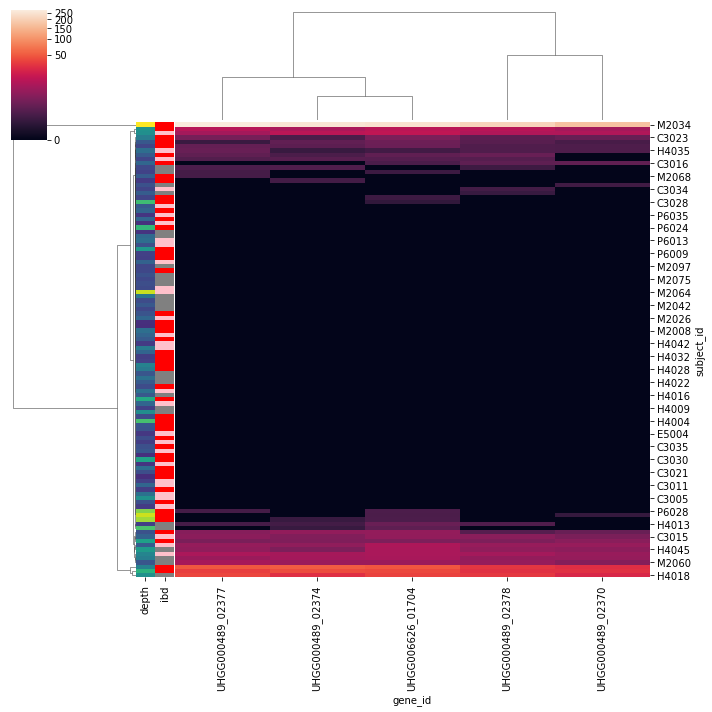

In [120]:
gene_list = ribose_gene_cluster_list
d = gene_depth.sel(gene_id=gene_list).to_series().unstack('gene_id').groupby(sample_meta.subject_id).sum()
depth = species_depth.groupby(sample_meta.subject_id).sum()
depth_colors = ((depth / depth.max())**(1/4)).map(mpl.cm.viridis)
diagnosis_colors = subject.loc[d.index].ibd_diagnosis.map({'CD': 'red', 'UC': 'pink', 'nonIBD': 'grey'})

sns.clustermap(
    d,
    row_colors=depth_colors.to_frame('depth').assign(ibd=diagnosis_colors),
    # metric='cosine',
    norm=mpl.colors.PowerNorm(1/4),
)


#### fructose/mannose catabolism

In [142]:
strain_list = high_power_strain_list
this_cog_pathway = 'C'
cog_list = cog_x_category[cog_x_category.category == this_cog_category].cog.unique()
gene_list = list(
    set(idxwhere(gene_meta.cog.isin(cog_list)))
    & set(idxwhere(moderate_hit[strain_list].mean(1) > 0.05))
)
guide_gene = 'UHGG033023_00488'
# gene_list = idxwhere(high_confidence_hit[strain_list].mean(1) > 0.05)

x = strain_depth.loc[gene_list, strain_list]

_gene_cluster_list = idxwhere(
    pd.DataFrame(sp.spatial.distance.squareform(sp.spatial.distance.pdist(x, metric='cosine')), index=x.index, columns=x.index)
    .loc[guide_gene].sort_values() < 0.05
)
print(len(_gene_cluster_list))

mannose_gene_cluster_list = _gene_cluster_list  # FIXME

gene_meta.join(cog_meta, on='cog', rsuffix='_cog_name').loc[_gene_cluster_list][['gene', 'ec_number', 'cog', 'product', 'description', 'gene_cog_name', 'pathway']]

9


,gene,ec_number,cog,product,description,gene_cog_name,pathway
gene_id,,,,,,,
UHGG033023_00488,sorA,NaN,COG3715,PTS system sorbose-specific EIIC component,"Phosphotransferase system, mannose/fructose/N-...",ManY,NaN
UHGG145324_03505,sorB_2,2.7.1.206,COG3444,PTS system sorbose-specific EIIB component,"Phosphotransferase system, mannose/fructose/N-...",AgaB,NaN
UHGG000026_02119,manR,NaN,COG1762,Transcriptional regulator ManR,Phosphotransferase system mannitol/fructose-sp...,PtsN,NaN
UHGG145202_01449,manP_1,NaN,COG1299,PTS system mannose-specific EIIBCA component,"Phosphotransferase system, fructose-specific I...",FrwC,NaN
UHGG000026_02122,fruA_3,NaN,COG1299,PTS system fructose-specific EIIB'BC component,"Phosphotransferase system, fructose-specific I...",FrwC,NaN
UHGG000026_02124,fbaA_1,4.1.2.13,COG0191,putative fructose-bisphosphate aldolase,Fructose/tagatose bisphosphate aldolase,Fba,Glycolysis
UHGG145025_02144,sorF,NaN,COG2893,PTS system sorbose-specific EIIA component,"Phosphotransferase system, mannose/fructose-sp...",ManX,NaN
UHGG145043_03639,malX_2,NaN,COG1263,PTS system maltose-specific EIICB component,"Phosphotransferase system IIC components, gluc...",PtsG1,NaN
UHGG116408_00573,mak_1,2.7.1.4,COG1940,Fructokinase,"Sugar kinase of the NBD/HSP70 family, may cont...",NagC,NaN


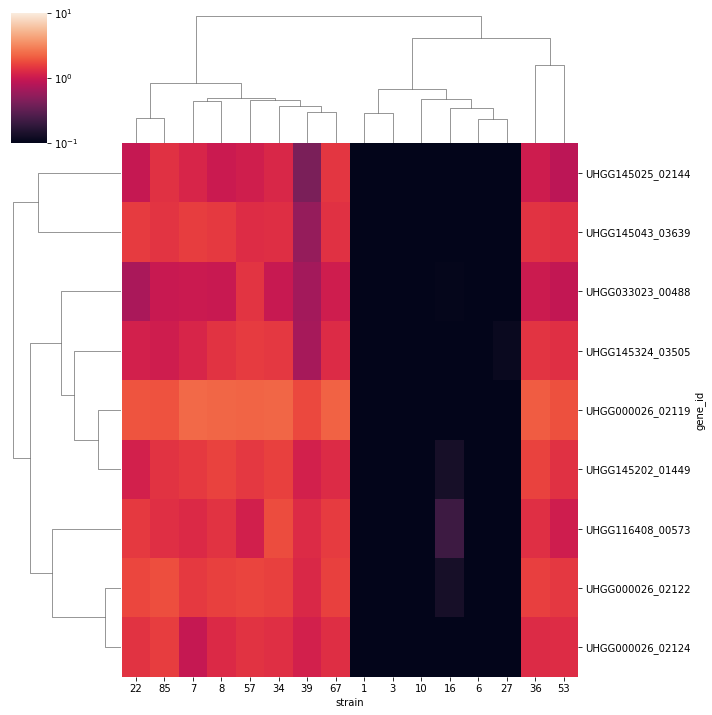

In [143]:
strain_list = high_power_strain_list
gene_list = mannose_gene_cluster_list

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    cg = sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=1,
        xticklabels=1,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

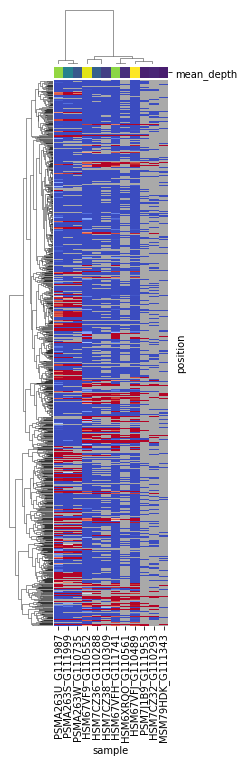

In [144]:
sample_list = strain_to_sample_list[53] + strain_to_sample_list[27]
sf.plot.plot_metagenotype(fit.sel(sample=sample_list, position=position_ss), row_linkage_func=lambda w: w.genotype.linkage('position'))

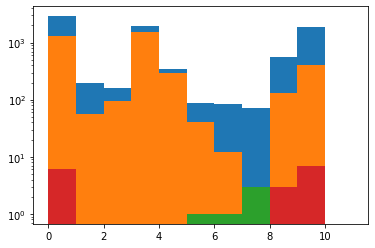

In [151]:
gene_list = mannose_gene_cluster_list

x = (reference_gene > 0).reindex(gene_list).fillna(False)
y = (isolate_gene > 0).reindex(gene_list).fillna(False)
z = high_confidence_hit[high_power_strain_list].reindex(gene_list).fillna(False)
a = moderate_hit[high_power_strain_list].reindex(gene_list).fillna(False)


bins = np.arange(len(gene_list) + 3)
plt.hist(x.sum(), bins=bins)
plt.hist(y.sum(), bins=bins)
plt.hist(z.sum(), bins=bins)
plt.hist(a.sum(), bins=bins)

plt.yscale('log')

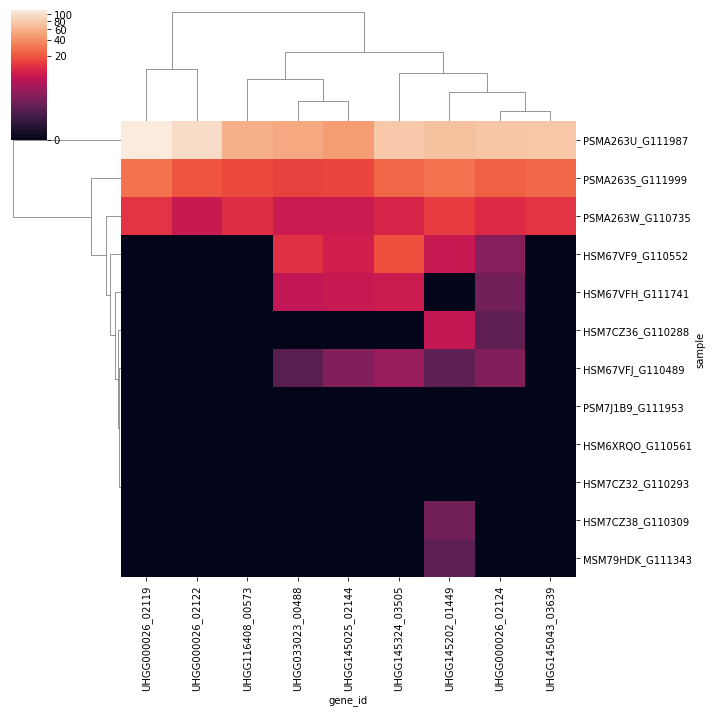

In [153]:
gene_list = mannose_gene_cluster_list
d = gene_depth.sel(gene_id=gene_list, sample=sample_list).to_series().unstack('gene_id')

sns.clustermap(
    d,
    # metric='cosine',
    norm=mpl.colors.PowerNorm(1/4),
)


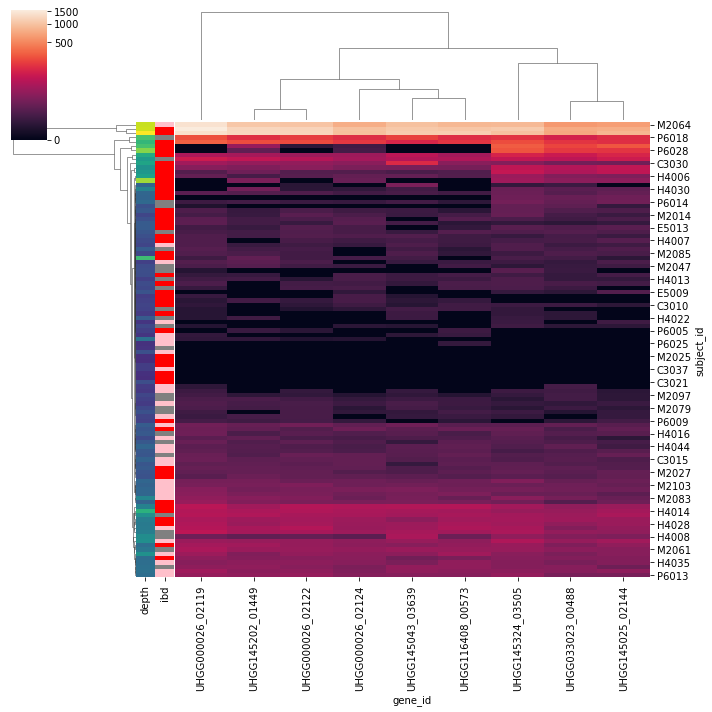

In [154]:
gene_list = mannose_gene_cluster_list
d = gene_depth.sel(gene_id=gene_list).to_series().unstack('gene_id').groupby(sample_meta.subject_id).sum()
depth = species_depth.groupby(sample_meta.subject_id).sum()
depth_colors = ((depth / depth.max())**(1/4)).map(mpl.cm.viridis)
diagnosis_colors = subject.loc[d.index].ibd_diagnosis.map({'CD': 'red', 'UC': 'pink', 'nonIBD': 'grey'})

sns.clustermap(
    d,
    row_colors=depth_colors.to_frame('depth').assign(ibd=diagnosis_colors),
    # metric='cosine',
    norm=mpl.colors.PowerNorm(1/4),
)


### What about within cell envelope?

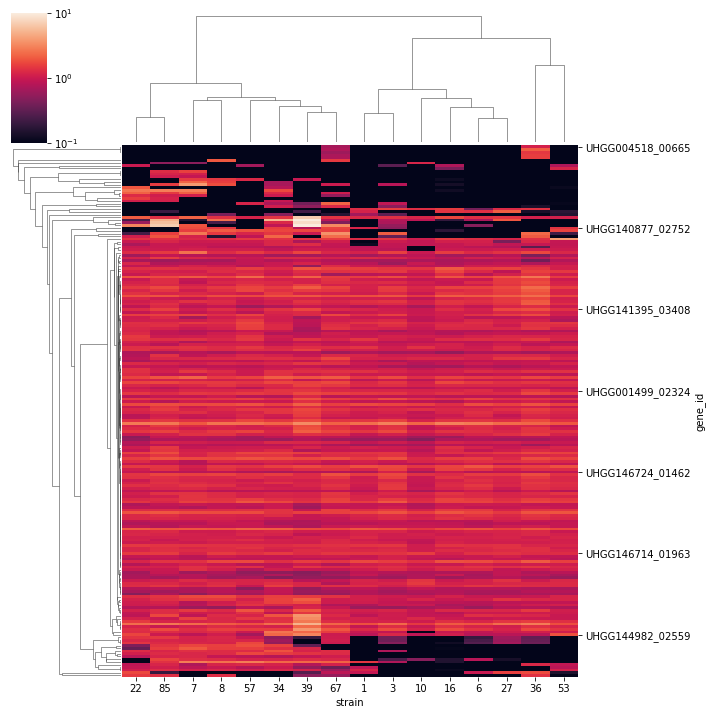

In [185]:
strain_list = high_power_strain_list
this_cog_category = 'M'
cog_list = cog_x_category[cog_x_category.category == this_cog_category].cog.unique()
gene_list = list(
    set(idxwhere(gene_meta.cog.isin(cog_list)))
    & set(idxwhere(high_confidence_hit[strain_list].mean(1) > 0.1))
)

x = strain_depth.loc[gene_list, strain_list]
# x = high_confidence_hit.loc[gene_list, strain_list]


if len(gene_list) < 2e4:
    cg = sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=30,
        xticklabels=1,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

#### O-antigen genes?

In [188]:
strain_list = high_power_strain_list
this_cog_pathway = 'C'
cog_list = cog_x_category[cog_x_category.category == this_cog_category].cog.unique()
gene_list = list(
    set(idxwhere(gene_meta.cog.isin(cog_list)))
    & set(idxwhere(high_confidence_hit[strain_list].mean(1) > 0.05))
)
guide_gene = 'UHGG004518_00665'
# gene_list = idxwhere(high_confidence_hit[strain_list].mean(1) > 0.05)

x = strain_depth.loc[gene_list, strain_list]

_gene_cluster_list = idxwhere(
    pd.DataFrame(sp.spatial.distance.squareform(sp.spatial.distance.pdist(x, metric='cosine')), index=x.index, columns=x.index)
    .loc[guide_gene].sort_values() < 0.1
)
print(len(_gene_cluster_list))

x_gene_cluster_list = _gene_cluster_list  # FIXME

gene_meta.join(cog_meta, on='cog', rsuffix='_cog_name').loc[_gene_cluster_list][['gene', 'ec_number', 'cog', 'product', 'description', 'gene_cog_name', 'pathway']]

5


,gene,ec_number,cog,product,description,gene_cog_name,pathway
gene_id,,,,,,,
UHGG004518_00665,rfbD_1,1.1.1.133,COG1091,dTDP-4-dehydrorhamnose reductase,dTDP-4-dehydrorhamnose reductase,RfbD,NaN
UHGG004518_00664,rfbB_1,4.2.1.46,COG1088,"dTDP-glucose 4,6-dehydratase","dTDP-D-glucose 4,6-dehydratase",RfbB,NaN
UHGG004518_00667,rfbC_1,5.1.3.13,COG1898,"dTDP-4-dehydrorhamnose 3,5-epimerase","dTDP-4-dehydrorhamnose 3,5-epimerase or relate...",RfbC,NaN
UHGG004518_00666,rmlA,2.7.7.24,COG1209,Glucose-1-phosphate thymidylyltransferase,dTDP-glucose pyrophosphorylase,RmlA1,NaN
UHGG004518_00653,kpsD,NaN,COG1596,Polysialic acid transport protein KpsD,Periplasmic protein Wza involved in polysaccha...,Wza,NaN


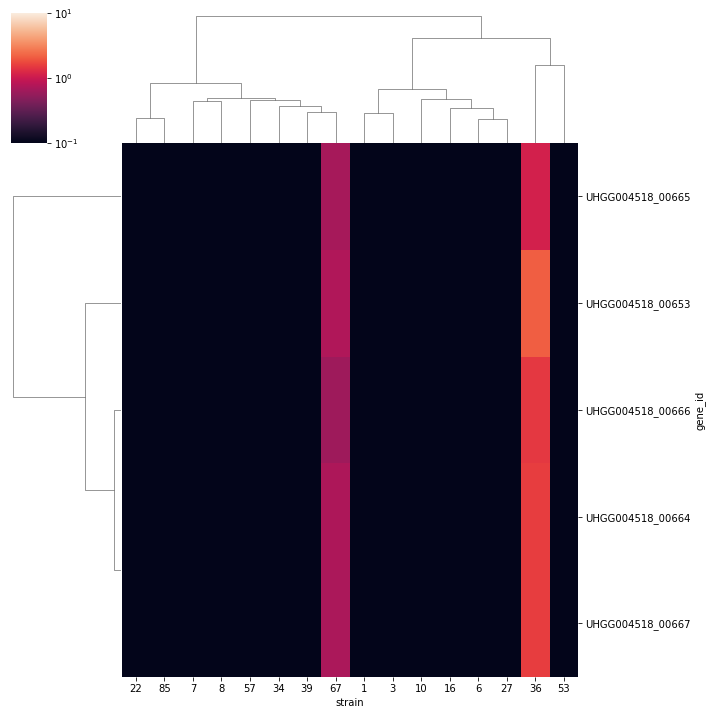

In [189]:
strain_list = high_power_strain_list
gene_list = x_gene_cluster_list

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    cg = sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=1,
        xticklabels=1,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

In [ ]:
from itertools import chain

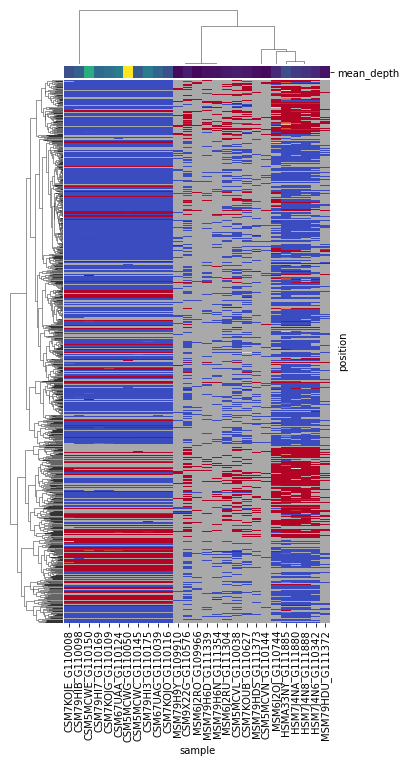

In [201]:
strain_list = [36, 67, 39]
sample_list = list(chain.from_iterable(strain_to_sample_list[s] for s in strain_list))
sf.plot.plot_metagenotype(fit.sel(sample=sample_list, position=position_ss), row_linkage_func=lambda w: w.genotype.linkage('position'))

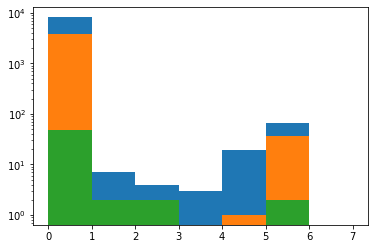

In [202]:
gene_list = x_gene_cluster_list

x = (reference_gene > 0).reindex(gene_list).fillna(False)
y = (isolate_gene > 0).reindex(gene_list).fillna(False)
z = high_confidence_hit.reindex(gene_list).fillna(False)

bins = np.arange(len(gene_list) + 3)
plt.hist(x.sum(), bins=bins)
plt.hist(y.sum(), bins=bins)
plt.hist(z.sum(), bins=bins)

plt.yscale('log')

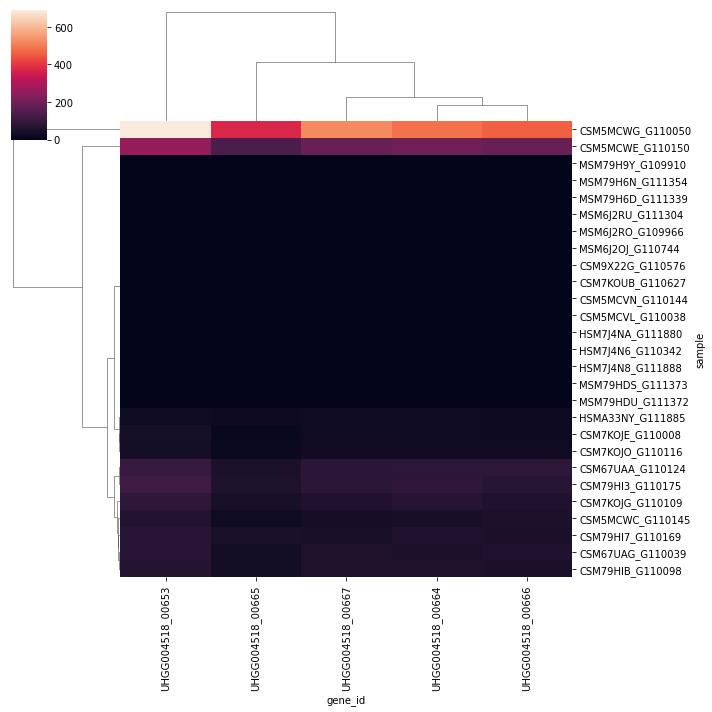

In [ ]:
gene_list = x_gene_cluster_list
d = gene_depth.sel(gene_id=gene_list, sample=sample_list).to_series().unstack('gene_id')

sns.clustermap(
    d,
    # metric='cosine',
    # norm=mpl.colors.PowerNorm(1/4),
)


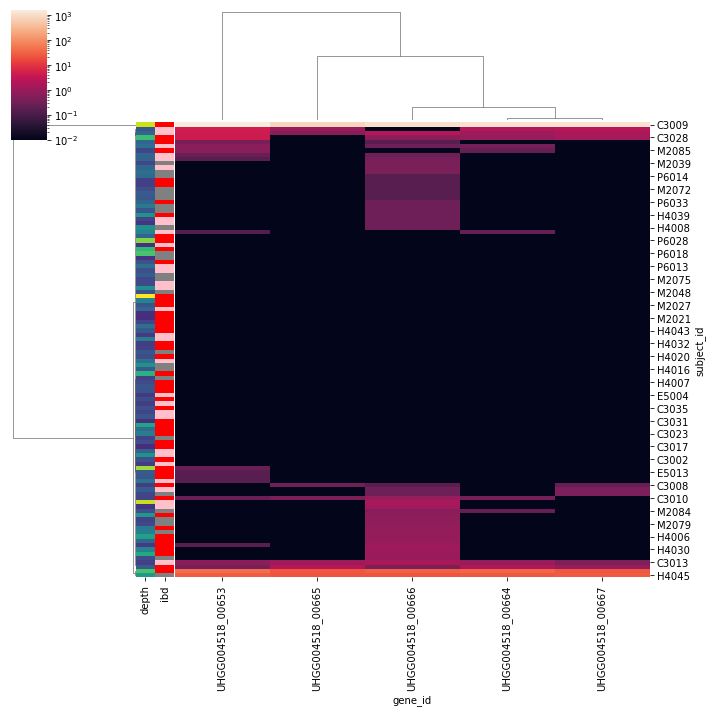

In [207]:
gene_list = x_gene_cluster_list
d = gene_depth.sel(gene_id=gene_list).to_series().unstack('gene_id').groupby(sample_meta.subject_id).sum()
depth = species_depth.groupby(sample_meta.subject_id).sum()
depth_colors = ((depth / depth.max())**(1/4)).map(mpl.cm.viridis)
diagnosis_colors = subject.loc[d.index].ibd_diagnosis.map({'CD': 'red', 'UC': 'pink', 'nonIBD': 'grey'})

sns.clustermap(
    d + 1e-2,
    row_colors=depth_colors.to_frame('depth').assign(ibd=diagnosis_colors),
    # metric='cosine',
    norm=mpl.colors.LogNorm(),
)


In [216]:
sample_meta.assign(strain_rabund=fit.community.data.sel(strain=67).to_series()).groupby('subject_id').strain_rabund.mean().sort_values(ascending=False)

subject_id
H4028    0.501525
C3013    0.273275
M2068    0.222222
H4045    0.126785
P6016    0.125143
           ...   
M2021         NaN
M2025         NaN
P6017         NaN
P6025         NaN
P6035         NaN
Name: strain_rabund, Length: 106, dtype: float32

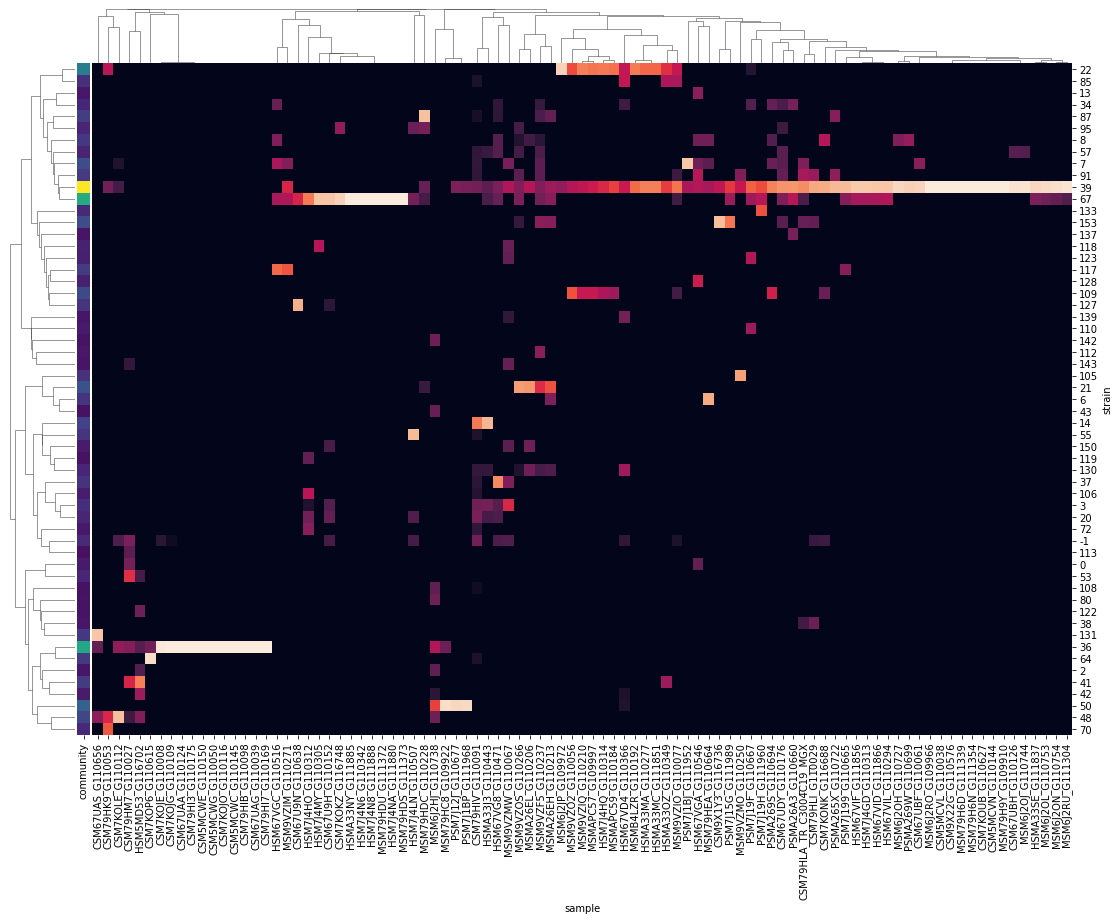

In [210]:
sample_list = idxwhere((fit.community.data.sel(strain=strain_list) > 0.05).any("strain").to_series())
sf.plot.plot_community(fit.sel(sample=sample_list).drop_low_abundance_strains(0.05), row_linkage_func=lambda w: w.genotype.linkage("strain"))

In [ ]:
gene_list = x_gene_cluster_list
d = gene_depth.sel(gene_id=gene_list, sample=sample_list).to_series().unstack('gene_id')

sns.clustermap(
    d,
    norm=mpl.colors.PowerNorm(1/4),
)


#### O-antigen genes

In [ ]:
strain_list = high_power_strain_list
this_cog_pathway = 'C'
cog_list = cog_x_category[cog_x_category.category == this_cog_category].cog.unique()
gene_list = list(
    set(idxwhere(gene_meta.cog.isin(cog_list)))
    & set(idxwhere(high_confidence_hit[strain_list].mean(1) > 0.05))
)
guide_gene = 'UHGG004518_00665'
# gene_list = idxwhere(high_confidence_hit[strain_list].mean(1) > 0.05)

x = strain_depth.loc[gene_list, strain_list]

_gene_cluster_list = idxwhere(
    pd.DataFrame(sp.spatial.distance.squareform(sp.spatial.distance.pdist(x, metric='cosine')), index=x.index, columns=x.index)
    .loc[guide_gene].sort_values() < 0.15
)
print(len(_gene_cluster_list))

x_gene_cluster_list = _gene_cluster_list  # FIXME

gene_meta.join(cog_meta, on='cog', rsuffix='_cog_name').loc[_gene_cluster_list][['gene', 'ec_number', 'cog', 'product', 'description', 'gene_cog_name', 'pathway']]

In [ ]:
strain_list = high_power_strain_list
gene_list = x_gene_cluster_list

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    cg = sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=1,
        xticklabels=1,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

In [ ]:
strain_list = [36, 67, 81]
sample_list = list(chain.from_iterable(strain_to_sample_list[s] for s in strain_list))
sf.plot.plot_metagenotype(fit.sel(sample=sample_list, position=position_ss), row_linkage_func=lambda w: w.genotype.linkage('position'))

In [ ]:
gene_list = x_gene_cluster_list

x = (reference_gene > 0).reindex(gene_list).fillna(False)
y = (isolate_gene > 0).reindex(gene_list).fillna(False)
z = high_confidence_hit.reindex(gene_list).fillna(False)
a = high_confidence_hit[high_power_strain_list].reindex(gene_list).fillna(False)


bins = np.arange(len(gene_list) + 3)
plt.hist(x.sum(), bins=bins)
plt.hist(y.sum(), bins=bins)
plt.hist(z.sum(), bins=bins)
plt.hist(a.sum(), bins=bins)


plt.yscale('log')

In [ ]:
gene_list = x_gene_cluster_list
d = gene_depth.sel(gene_id=gene_list, sample=sample_list).to_series().unstack('gene_id')

sns.clustermap(
    d,
    # metric='cosine',
    norm=mpl.colors.PowerNorm(1/4),
)


In [ ]:
gene_list = x_gene_cluster_list
d = gene_depth.sel(gene_id=gene_list).to_series().unstack('gene_id').groupby(sample_meta.subject_id).sum()
depth = species_depth.groupby(sample_meta.subject_id).sum()
depth_colors = ((depth / depth.max())**(1/4)).map(mpl.cm.viridis)
diagnosis_colors = subject.loc[d.index].ibd_diagnosis.map({'CD': 'red', 'UC': 'pink', 'nonIBD': 'grey'})

sns.clustermap(
    d,
    row_colors=depth_colors.to_frame('depth').assign(ibd=diagnosis_colors),
    # metric='cosine',
    norm=mpl.colors.PowerNorm(1/4),
)


In [ ]:
sf.plot.plot_community(fit.sel(sample=sample_list).drop_low_abundance_strains(0.05), row_linkage_func=lambda w: w.genotype.linkage("strain"))

In [ ]:
gene_list = x_gene_cluster_list
d = gene_depth.sel(gene_id=gene_list, sample=sample_list).to_series().unstack('gene_id')

sns.clustermap(
    d,
    norm=mpl.colors.PowerNorm(1/4),
)


### What about within defense?

In [ ]:
strain_list = high_power_strain_list
this_cog_category = 'V'
cog_list = cog_x_category[cog_x_category.category == this_cog_category].cog.unique()
gene_list = list(
    set(idxwhere(gene_meta.cog.isin(cog_list)))
    & set(idxwhere((high_confidence_hit[strain_list].mean(1) > 0.05) & (high_confidence_not_hit[strain_list].mean(1) > 0.2)))
)

x = strain_depth.loc[gene_list, strain_list]
# x = high_confidence_hit.loc[gene_list, strain_list]


if len(gene_list) < 2e4:
    cg = sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=2,
        xticklabels=1,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
        # figsize=(7, 20),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

#### X genes?

In [ ]:
strain_list = high_power_strain_list
this_cog_pathway = 'C'
cog_list = cog_x_category[cog_x_category.category == this_cog_category].cog.unique()
gene_list = list(
    set(idxwhere(gene_meta.cog.isin(cog_list)))
    & set(idxwhere(high_confidence_hit[strain_list].mean(1) > 0.05))
)
guide_gene = 'UHGG153923_03568'
# gene_list = idxwhere(high_confidence_hit[strain_list].mean(1) > 0.05)

x = strain_depth.loc[gene_list, strain_list]

_gene_cluster_list = idxwhere(
    pd.DataFrame(sp.spatial.distance.squareform(sp.spatial.distance.pdist(x, metric='cosine')), index=x.index, columns=x.index)
    .loc[guide_gene].sort_values() < 0.1
)
print(len(_gene_cluster_list))

x_gene_cluster_list = _gene_cluster_list  # FIXME

gene_meta.join(cog_meta, on='cog', rsuffix='_cog_name').loc[_gene_cluster_list][['gene', 'ec_number', 'cog', 'product', 'description', 'gene_cog_name', 'pathway']]

In [ ]:
strain_list = high_power_strain_list
gene_list = x_gene_cluster_list

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    cg = sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=1,
        xticklabels=1,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

In [ ]:
strain_list = [16, 6, 27]
sample_list = list(chain.from_iterable(strain_to_sample_list[s] for s in strain_list))
sf.plot.plot_metagenotype(
    fit.sel(sample=sample_list, position=position_ss),
    row_linkage_func=lambda w: w.genotype.linkage('position'),
    col_linkage_func=lambda w: w.metagenotype.linkage(),
)

In [ ]:
sf.plot.plot_community(
    fit.sel(sample=sample_list, position=position_ss).drop_low_abundance_strains(0.05),
    row_linkage_func=lambda w: w.genotype.linkage('strain'),
    col_linkage_func=lambda w: w.metagenotype.linkage(),
)

In [ ]:
gene_list = x_gene_cluster_list

x = (reference_gene > 0).reindex(gene_list).fillna(False)
y = (isolate_gene > 0).reindex(gene_list).fillna(False)
z = high_confidence_hit.reindex(gene_list).fillna(False)
a = high_confidence_hit[high_power_strain_list].reindex(gene_list).fillna(False)


bins = np.arange(len(gene_list) + 3)
plt.hist(x.sum(), bins=bins, alpha=0.5)
plt.hist(y.sum(), bins=bins, alpha=0.5)
plt.hist(z.sum(), bins=bins, alpha=0.5)
plt.hist(a.sum(), bins=bins, alpha=0.5)


plt.yscale('log')

In [ ]:
gene_list = x_gene_cluster_list
d = gene_depth.sel(gene_id=gene_list, sample=sample_list).to_series().unstack('gene_id')

sns.clustermap(
    d,
    # metric='cosine',
    norm=mpl.colors.PowerNorm(1/4),
)


In [ ]:
gene_list = x_gene_cluster_list
d = gene_depth.sel(gene_id=gene_list).to_series().unstack('gene_id').groupby(sample_meta.subject_id).sum()
depth = species_depth.groupby(sample_meta.subject_id).sum()
depth_colors = ((depth / depth.max())**(1/4)).map(mpl.cm.viridis)
diagnosis_colors = subject.loc[d.index].ibd_diagnosis.map({'CD': 'red', 'UC': 'pink', 'nonIBD': 'grey'})

sns.clustermap(
    d + 1e-5,
    row_colors=depth_colors.to_frame('depth').assign(ibd=diagnosis_colors),
    metric='cosine',
    norm=mpl.colors.PowerNorm(1/4),
)


# Do strain-private genes show up in samples with that strain at less than 100%?

In [228]:
strain_meta.loc[8]

corr_threshold_strict       0.979613
corr_threshold_moderate     0.967908
corr_threshold_lenient      0.914441
depth_thresh_low            0.542215
depth_thresh_high           1.922449
genotype_entropy            0.058286
metagenotype_entropy        0.002158
num_samples                78.000000
depth_stdev                 0.963933
depth_max                   5.672279
depth_sum                  99.327870
power_index                 8.513228
Name: 8, dtype: float64

In [325]:
strain = 8

strain_private_genes = idxwhere(high_confidence_hit[strain] & (moderate_hit.sum(1) == 1))
gene_meta.join(cog_meta, on='cog', rsuffix='_cog_name').loc[strain_private_genes][['gene', 'ec_number', 'cog', 'product', 'description', 'gene_cog_name', 'pathway']]

,gene,ec_number,cog,product,description,gene_cog_name,pathway
gene_id,,,,,,,
UHGG000533_02808,NaN,NaN,NaN,hypothetical protein,NaN,NaN,NaN
UHGG140226_00087,NaN,NaN,NaN,hypothetical protein,NaN,NaN,NaN
UHGG141917_01483,NaN,NaN,NaN,hypothetical protein,NaN,NaN,NaN
UHGG004289_00672,intA,NaN,COG0582,Prophage integrase IntA,"Integrase/recombinase, includes phage integrase",FimB,NaN
UHGG076068_02217,NaN,NaN,NaN,hypothetical protein,NaN,NaN,NaN
UHGG000930_04690,NaN,NaN,NaN,hypothetical protein,NaN,NaN,NaN
UHGG001882_01962,NaN,NaN,NaN,hypothetical protein,NaN,NaN,NaN
UHGG143908_04637,NaN,NaN,NaN,hypothetical protein,NaN,NaN,NaN
UHGG130445_03001,NaN,NaN,NaN,hypothetical protein,NaN,NaN,NaN


/pollard/home/bsmith/.snakemake/conda/204b2d5e194d4cedcf565e20990467c9/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


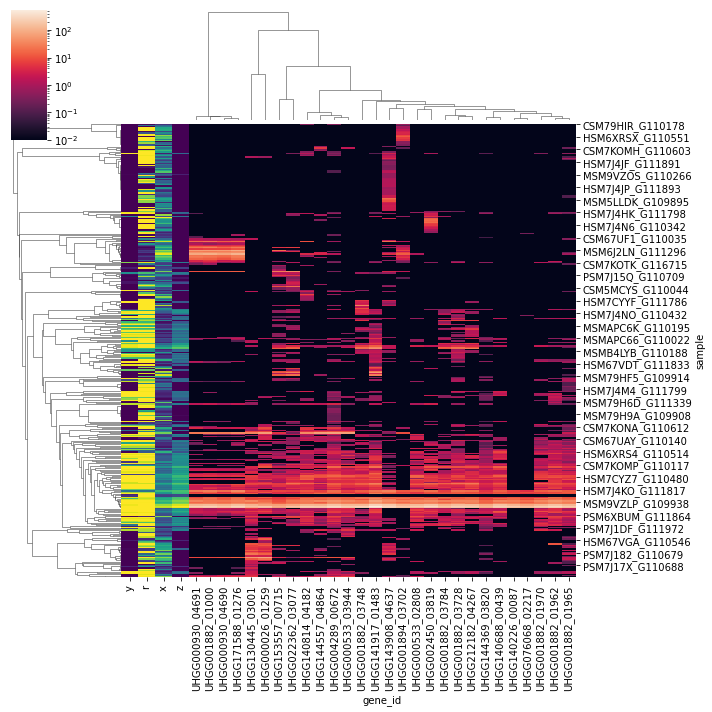

In [326]:
from lib.pandas_util import align_indexes

x = species_depth
y = fit.community.data.sel(strain=strain).to_series().reindex(x.index, fill_value=0)
r = fit.community.data.sel(strain=high_power_strain_list).sum("strain").to_series()
z = x * y
d = gene_depth.sel(gene_id=strain_private_genes).to_series().unstack('gene_id')
b = ((d.sum(1) > 1e-3) | (y > 1e-1))[lambda x: x]
x, y, r, z, d, b = align_indexes(x, y, r, z, d, b)

sns.clustermap(
    d + 1e-2,
    metric='cosine',
    norm=mpl.colors.LogNorm(),
    row_colors=pd.DataFrame(dict(
        y=y.map(mpl.cm.viridis),
        r=r.map(mpl.cm.viridis),
        x=np.log(x + 1e-2).pipe(lambda x: (x - x.min()) / (x.max() - x.min())).map(mpl.cm.viridis),
        z=np.log(z + 1e-2).pipe(lambda x: (x - x.min()) / (x.max() - x.min())).map(mpl.cm.viridis),
    ))
)

# Can we quantify the degree of genotype co-similarity between genes and SNPs?